In [ ]:
import torch

from learnedMethodForHologram import *
from learnedMethodForHologram.optics import bandLimitedAngularSpectrumMethod as BLASM_v1
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod as BLASM_v2,
)

# about the data loader

In [ ]:
# # convert the .exr data to torch tensors
# data_processor.read_exr_in_multi_folders(
#     "data\\test_192", channlesNum=3, height=192, width=192
# )
# data_processor.read_exr_in_multi_folders(
#     "data\\test_384", channlesNum=3, height=384, width=384
# )

# read the header of the .exr data using OpenEXR
import OpenEXR
import Imath

exrFile = OpenEXR.InputFile("data/test_192/amp/3900.exr")
header = exrFile.header()
dw = header["dataWindow"]
sz = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)
print("The size of the image is: ", sz)
print(f"the channel names are: {header['channels']}")

In [ ]:
dataset = data_processor.data_loader(
    "data\\test_192\\amp.bin",
    "data\\test_192\\phs.bin",
    "data\\test_192\\img.bin",
    "data\\test_192\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
)

dataLoader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0
)

In [ ]:
amp, phs, img, depth = next(iter(dataLoader))
utilities.multi_channel_plotter(
    utilities.tensor_normalizor_2D(amp), title=None, rgb_img=True
)
utilities.multi_channel_plotter(
    utilities.tensor_normalizor_2D(phs), title=None, rgb_img=True
)
utilities.multi_channel_plotter(
    utilities.tensor_normalizor_2D(img), title=None, rgb_img=True
)
utilities.multi_channel_plotter(
    utilities.tensor_normalizor_2D(depth), title=None, rgb_img=True
)

In [ ]:
amp, phs, img, depth = next(iter(dataLoader))
depth_np = depth.squeeze().numpy()
print(depth_np.max(), depth_np.min())

In [ ]:
import torch
from learnedMethodForHologram import *

dataset = data_processor.data_loader_A_B(
    path_A = "data\\MIT_CGH_192_bin\\train\\img.bin",
    path_B = "data\\MIT_CGH_192_bin\\train\\depth.bin",
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
    padding=False,
    cuda=True,
)

dataLoader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=0)

%timeit img_depth_tensor = next(iter(dataLoader))
img_depth_tensor = next(iter(dataLoader))

print(f"the max value of the img is {img_depth_tensor[:,0].max()}")   


## data_loader_for_percepetual_loss

In [ ]:
import torch
from learnedMethodForHologram.data_processor import data_loader_for_percepetual_loss
from learnedMethodForHologram import utilities

# "data\\test_192\\amp.bin",
# "data\\test_192\\phs.bin",
# "data\\test_192\\img.bin",
# "data\\test_192\\depth.bin",

dataset = data_loader_for_percepetual_loss(
    path_amp="data\\test_192\\img.bin",
    path_phs="data\\test_192\\phs.bin",
    path_depth="data\\test_192\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=False,
)

dataLoader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0
)

amp_phs_depth_tensor = next(iter(dataLoader))

print(amp_phs_depth_tensor[:, :3].shape)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amp_phs_depth_tensor[:, :3]),
    titles=None,
    rgb_img=True,
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amp_phs_depth_tensor[:, 3:-1]),
    titles=None,
    rgb_img=True,
)

utilities.multi_channel_plotter(
    utilities.tensor_normalizor_2D(amp_phs_depth_tensor[:, -1]),
    title=None,
    color=1,
)

# about band_limited_angular_spectrum_method(V1)

In [ ]:
torch.cuda.empty_cache()

distances = torch.tensor(
    [0.0, 2.5e-2, 5.0e-3, 7.5e-3, 1.0e-2, 5.0e-2, 10.0e-2, 20.0e-3]
)
propagator = BLASM_v1(distances=distances)
%timeit propagator.band_limited_angular_spectrum_multichannels()

del(propagator)
torch.cuda.empty_cache()

In [ ]:
# clear the cache
torch.cuda.empty_cache()

distances = torch.linspace(0, 2.5e-3, 3)
propagator = BLASM_v1(distances=distances, band_limit=True)
g_z_complex = propagator.band_limited_angular_spectrum_multichannels()
intensity = utilities.intensity_calculator(g_z_complex, True)
utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(intensity), titles=None, rgb_img=True
)

# about band_limited_angular_spectrum_method(V2)

In [ ]:
from tests import *

test_bandlimited_agular_spectrum_approach.test()

## dataset_192

In [ ]:
import torch
from learnedMethodForHologram import *

dataset = data_processor.data_loader(
    "data\\MIT_CGH_192_bin\\train\\amp.bin",
    "data\\MIT_CGH_192_bin\\train\\phs.bin",
    "data\\MIT_CGH_192_bin\\train\\img.bin",
    "data\\MIT_CGH_192_bin\\train\\depth.bin",
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
)

dataLoader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0
)
sampleX = next(iter(dataLoader))

In [ ]:
amplitude_tensor = sampleX[0]
phase_tensor = sampleX[1]
distances = torch.linspace(-2e-4, 2e-4, 7)
# spacial_frequency_filter = (
#     utilities.generate_custom_frequency_mask(
#         sample_row_num=2400,
#         sample_col_num=4094,
#         x=800,
#         y=int(800 * 4094 / 2400),
#     )
# )
propagator = bandlimited_angular_spectrum_approach.bandLimitedAngularSpectrumMethod(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
)
intensities = propagator(
    amplitute_tensor=amplitude_tensor,
    phase_tensor=phase_tensor,
    distances=distances,
    # spacial_frequency_filter=spacial_frequency_filter,
)
normalized_intensities = utilities.tensor_normalizor_2D(intensities)

utilities.multi_sample_plotter(
    normalized_intensities,
    titles=None,
    rgb_img=True,
    save_dir="output\\test_output\\blasm_v2_dataset_192",
    color=0,
)

## dataset_384

In [ ]:
import torch
from learnedMethodForHologram import *

dataset = data_processor.data_loader(
    "data\\MIT_CGH_384_bin\\test\\amp.bin",
    "data\\MIT_CGH_384_bin\\test\\phs.bin",
    "data\\MIT_CGH_384_bin\\test\\img.bin",
    "data\\MIT_CGH_384_bin\\test\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=384,
    width=384,
)

dataLoader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0
)
sampleX = next(iter(dataLoader))

In [ ]:
amplitude_tensor = sampleX[0]
phase_tensor = sampleX[1]
distances = torch.linspace(-0.15e-4, 10e-4, 7)
# spacial_frequency_filter = (
#     utilities.generate_custom_frequency_mask(
#         sample_row_num=2400,
#         sample_col_num=4094,
#         x=800,
#         y=int(800 * 4094 / 2400),
#     )
# )
propagator = bandlimited_angular_spectrum_approach.bandLimitedAngularSpectrumMethod(
    sample_row_num=384,
    sample_col_num=384,
    pixel_pitch=8e-6,
    wave_length=torch.tensor([638e-9, 520e-9, 450e-9]),
    band_limit=False,
    cuda=False,
)
intensities = propagator(
    amplitute_tensor=amplitude_tensor,
    phase_tensor=phase_tensor,
    distances=distances,
    # spacial_frequency_filter=spacial_frequency_filter,
)
normalized_intensities = utilities.tensor_normalizor_2D(intensities)

utilities.multi_sample_plotter(
    normalized_intensities,
    titles=None,
    rgb_img=True,
    save_dir="output\\test_output\\blasm_v2_dataset_384",
    color=0,
)

# about BLASM_v2 and v3

In [ ]:
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod as BLASM_v2,
)
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_single_fixed_distance as BLASM_v3,
)

propagator_v2 = BLASM_v2(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
)

w_grid_v2 = propagator_v2.generate_w_grid()
transfer_function_v2 = propagator_v2.generate_transfer_function(
    distances=torch.tensor([2.5e-3])
)
print(transfer_function_v2.shape)

propagator_v3 = BLASM_v3(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
    distance=torch.tensor([2.5e-3]),
)

w_grid_v3 = propagator_v3.generate_w_grid()
transfer_function_v3 = propagator_v3.generate_transfer_function()
print(transfer_function_v3.shape)

assert torch.allclose(w_grid_v2, w_grid_v3)
assert torch.allclose(transfer_function_v2, transfer_function_v3)

## dataset_192 with padding

In [ ]:
import torch
from learnedMethodForHologram import *

dataset = data_processor.data_loader(
    "data\\MIT_CGH_192_bin\\train\\amp.bin",
    "data\\MIT_CGH_192_bin\\train\\phs.bin",
    "data\\MIT_CGH_192_bin\\train\\img.bin",
    "data\\MIT_CGH_192_bin\\train\\depth.bin",
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
    padding=True,  # padding the input data to 256x256
    cuda=False,
)

dataLoader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0
)
sampleX = next(iter(dataLoader))

print(sampleX[0].shape)

In [ ]:
amplitude_tensor = sampleX[0]
phase_tensor = sampleX[1]
distances = torch.linspace(-1.5e-4, 1.5e-4, 7)
# spacial_frequency_filter = (
#     utilities.generate_custom_frequency_mask(
#         sample_row_num=2400,
#         sample_col_num=4094,
#         x=800,
#         y=int(800 * 4094 / 2400),
#     )
# )
propagator = bandlimited_angular_spectrum_approach.bandLimitedAngularSpectrumMethod(
    sample_row_num=512,
    sample_col_num=512,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
)
intensities = propagator(
    amplitute_tensor=amplitude_tensor,
    phase_tensor=phase_tensor,
    distances=distances,
    # spacial_frequency_filter=spacial_frequency_filter,
)
normalized_intensities = utilities.tensor_normalizor_2D(intensities)

utilities.multi_sample_plotter(
    normalized_intensities,
    titles=None,
    rgb_img=True,
    save_dir="output\\test_output\\blasm_v2_dataset_192_padding_512",
    color=0,
)

# model training

In [ ]:
import torch
from learnedMethodForHologram import (
    bandlimited_angular_spectrum_approach,
    neural_network_components,
)

propagator = bandlimited_angular_spectrum_approach.bandLimitedAngularSpectrumMethod(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
)

amps = torch.randn(4, 3, 192, 192)
phs = torch.randn(4, 3, 192, 192)

intensities = propagator(amps, phs, torch.tensor([0.0]))
print(f"intensities shape: {intensities.shape}")

amps = torch.randn(1, 3, 192, 192)
phs = torch.randn(1, 3, 192, 192)

intensities = propagator(amps, phs, torch.tensor([0.0]))
print(f"intensities shape: {intensities.shape}")

amps_phs = torch.randn(1, 6, 192, 192)

amp_phs = propagator.propagate_AP2AP(amps_phs, torch.tensor([0.0]))
print(f"propagate_AP2AP shape: {amp_phs.shape}")

amps = torch.randn(1, 3, 192, 192)
phs = torch.randn(1, 3, 192, 192)

intensities = propagator.propagate_P2I(phs, torch.tensor([0.0]))
print(f"propagate_P2I shape: {intensities.shape}")

amps_phs = torch.randn(4, 6, 192, 192)

amp_phs = propagator.propagate_AP2AP(amps_phs, torch.tensor([0.0]))
print(f"propagate_AP2AP shape: {amp_phs.shape}")

intensities = propagator.propagate_P2I(phs, torch.tensor([0.0]))
print(f"propagate_P2I shape: {intensities.shape}")

tensor1 = torch.randn(4, 4, 192, 192)
model = neural_network_components.UNet()
output = model(tensor1)
print(f"output shape of the UNet: {output.shape}")

tensor2 = torch.randn(4, 2, 192, 192)
model = neural_network_components.ResNet_POH()
output = model(tensor2)
print(f"output shape of the ResNet_POH: {output.shape}")

In [ ]:
import torch
from learnedMethodForHologram import (
    bandlimited_angular_spectrum_approach,
    neural_network_components,
)

propagator = bandlimited_angular_spectrum_approach.bandLimitedAngularSpectrumMethod_for_single_fixed_distance(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
    distance=torch.tensor([0.0]),
)

amps = torch.randn(4, 3, 192, 192)
phs = torch.randn(4, 3, 192, 192)

intensities = propagator(amps, phs)
print(f"intensities shape: {intensities.shape}")

amps = torch.randn(1, 3, 192, 192)
phs = torch.randn(1, 3, 192, 192)

intensities = propagator(amps, phs)
print(f"intensities shape: {intensities.shape}")

amps_phs = torch.randn(1, 6, 192, 192)

amp_phs = propagator.propagate_AP2AP(amps_phs)
print(f"propagate_AP2AP shape: {amp_phs.shape}")

amps = torch.randn(1, 3, 192, 192)
phs = torch.randn(1, 3, 192, 192)

intensities = propagator.propagate_P2I(phs)
print(f"propagate_P2I shape: {intensities.shape}")

amps_phs = torch.randn(4, 6, 192, 192)

amp_phs = propagator.propagate_AP2AP(amps_phs)
print(f"propagate_AP2AP shape: {amp_phs.shape}")

intensities = propagator.propagate_P2I(phs)
print(f"propagate_P2I shape: {intensities.shape}")

tensor1 = torch.randn(4, 4, 192, 192)
model = neural_network_components.UNet()
output = model(tensor1)
print(f"output shape of the UNet: {output.shape}")

tensor2 = torch.randn(4, 2, 192, 192)
model = neural_network_components.ResNet_POH()
output = model(tensor2)
print(f"output shape of the ResNet_POH: {output.shape}")

In [ ]:
model = neural_network_components.UNet()
model.eval()
%timeit output = model(tensor1)

model = neural_network_components.ResNet_POH()
%timeit output = model(tensor2)

In [ ]:
import torch
from learnedMethodForHologram.data_processor import data_loader_A_B
from learnedMethodForHologram.watermelon_v1 import watermelon_v1

batch_num = 4
dataset = data_loader_A_B(
    path_A="data\\MIT_CGH_192_bin\\train\\img.bin",
    path_B="data\\MIT_CGH_192_bin\\train\\depth.bin",
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_num,
    shuffle=True,
    num_workers=0,
)

batch = next(iter(dataLoader))
model = watermelon_v1(
    input_shape=batch.shape,
    propagation_distance=torch.tensor([2.5e-3]),
    cuda=True,
)
output = model(batch)

In [ ]:
import torch
from learnedMethodForHologram.data_processor import data_loader_A_B
from learnedMethodForHologram.watermelon_v1 import watermelon_v1

dataset_train = data_loader_A_B(
    path_A="data\\MIT_CGH_192_bin\\test\\img.bin",
    path_B="data\\MIT_CGH_192_bin\\test\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_dataset_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

dataset_test = data_loader_A_B(
    path_A="data\\MIT_CGH_192_bin\\validate\\img.bin",
    path_B="data\\MIT_CGH_192_bin\\validate\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_dataset_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

model = watermelon_v1(
    input_shape=(1, 4, 192, 192),
    propagation_distance=torch.tensor([2.5e-3]),
    cuda=True,
)

model.train_model(
    train_iter=dataLoader_dataset_train,
    test_iter=dataLoader_dataset_test,
    num_epochs=10,
    lr=1e-2,
)

# save the model
torch.save(model.state_dict(), "watermelon_v1.pth")

In [ ]:
import torch
from learnedMethodForHologram import utilities
from learnedMethodForHologram.data_processor import data_loader_A_B
from learnedMethodForHologram.watermelon_v1 import watermelon_v1


# load the model
model = watermelon_v1(
    input_shape=(1, 4, 192, 192),
    propagation_distance=torch.tensor([1e-3]),
    cuda=True,
)

model.load_state_dict(
    torch.load("output\\models\\watermelon_v2_trainedwith3800samples.pth")
)
model.eval()

dataset_test = data_loader_A_B(
    path_A="data\\MIT_CGH_192_bin\\test\\img.bin",
    path_B="data\\MIT_CGH_192_bin\\test\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_dataset_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

batch = next(iter(dataLoader_dataset_test))
output = model(batch).to("cpu").detach()
print(f"output type: {type(output)}")
print(f"output shape: {output.shape}")
print(f"output max: {output.max()}")
print(f"output min: {output.min()}")
utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(output),
    titles=["reconstructed intensity"],
    rgb_img=True,
)

# watermelon

## v1

In [ ]:
import torch
from learnedMethodForHologram.data_processor import data_loader_A_B
from learnedMethodForHologram.watermelon_v1 import watermelon_v1

dataset_train = data_loader_A_B(
    path_A="data/MIT_CGH_192_bin/test/img.bin",
    path_B="data/MIT_CGH_192_bin/test/depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

# dataset_train = data_loader_A_B(
#     path_A="data/MIT_CGH_192_bin/train/img.bin",
#     path_B="data/MIT_CGH_192_bin/train/depth.bin",
#     samplesNum=3800,
#     channlesNum=3,
#     height=192,
#     width=192,
#     cuda=True,
# )

dataLoader_dataset_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=True,
    num_workers=0,
)

dataset_test = data_loader_A_B(
    path_A="data/MIT_CGH_192_bin/validate/img.bin",
    path_B="data/MIT_CGH_192_bin/validate/depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_dataset_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

model = watermelon_v1(
    input_shape=(4, 4, 192, 192),
    propagation_distance=torch.tensor([1e-3]),
    cuda=True,
)

model.train_model(
    train_iter=dataLoader_dataset_train,
    test_iter=dataLoader_dataset_test,
    num_epochs=10,
    # with v1,v2 lr = 1e-3
    lr=1e-4,
)

# save the model
# torch.save(model.state_dict(), 'output\\models\\watermelon_v2_trainedwith3800samples.pth')

In [ ]:
import torch
from learnedMethodForHologram.data_processor import data_loader_A_B
from learnedMethodForHologram.watermelon_v1 import watermelon_v1

# load the model
model = watermelon_v1(
    input_shape=(1, 4, 192, 192),
    propagation_distance=torch.tensor([1e-3]),
    cuda=False,
)

# model.load_state_dict(torch.load('output\\models\\watermelon_v2_trainedwith3800samples.pth'))
model.load_state_dict(torch.load("output\\models\\watermelon_v3_lr_1e-4_.pth"))

model.eval()

dataset_test = data_loader_A_B(
    path_A="data/MIT_CGH_192_bin/test/img.bin",
    path_B="data/MIT_CGH_192_bin/test/depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=False,
)

dataLoader_dataset_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

In [ ]:
batch = next(iter(dataLoader_dataset_test)).detach()
amp_phs_z = model.part1(batch).detach()
amp_phs_0 = model.propagator.propagate_AP2AP(amp_phs_z).detach()
phs_0 = model.part2(amp_phs_0).detach()
intensity = model.propagator.propagate_P2I(phs_0).detach()

In [ ]:
from learnedMethodForHologram import utilities

input_phs_restruction = torch.cat((batch[:, 0:3], phs_0, intensity), dim=0)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(input_phs_restruction),
    titles=["ground_truth_at_z1", "POH_at_z0", "reconstructed_intensity_at_z1"],
    rgb_img=True,
    # save_dir="output\\images\\1"
)

In [ ]:
from learnedMethodForHologram import utilities
import matplotlib.pyplot as plt
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_single_fixed_distance as BLASM_v3,
)

propagator = BLASM_v3(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
    distance=torch.tensor([100e-5]),
)

amp_amp_phs = model.propagator.propagate_P2AAP(phs_0).detach()
amp_phs_z_0 = amp_amp_phs[:, 3:]
amp_phs_z_0_filtered = torch.fft.ifft2(
    torch.fft.fft2(amp_phs_z_0[:, :3] * torch.exp(1j * amp_phs_z_0[:, 3:]))
    * utilities.generate_circular_frequency_mask(192, 192, 60)
)

# amp_phs_z_1 = propagator.propagate_AP2AP(amp_phs_z_0)
# amp_phs_z_1_filtered = torch.fft.ifft2(
#     torch.fft.fft2(amp_phs_z_1[:, :3] * torch.exp(1j * amp_phs_z_1[:, 3:]))
#     * utilities.generate_circular_frequency_mask(192, 192, 20)
# )
amp_phs_z_1 = propagator(amp_phs_z_0[:, :3], amp_phs_z_0[:, 3:])


intensity_comparison = torch.cat(
    # ((amp_phs_z_0[:, :3]) ** 2, (amp_phs_z_1[:, :3]) ** 2), dim=0
    ((amp_phs_z_0[:, :3]) ** 2, (amp_phs_z_1[:, :3])),
    dim=0,
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(intensity_comparison),
    titles=None,
    rgb_img=True,
)

intensity_comparison_filtered = torch.cat(
    (
        # torch.abs(amp_phs_z_0_filtered) ** 2,
        # torch.abs(amp_phs_z_1_filtered) ** 2,
        torch.abs(amp_phs_z_0_filtered) ** 2,
        amp_phs_z_1,
    ),
    dim=0,
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(intensity_comparison_filtered),
    titles=None,
    rgb_img=True,
)

In [ ]:
from learnedMethodForHologram import utilities

input_phs_restruction = torch.cat((batch[:, 0:3], phs_0, intensity), dim=0)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(input_phs_restruction),
    titles=["ground_truth_at_z1", "POH_at_z0", "reconstructed_intensity_at_z1"],
    rgb_img=True,
    # save_dir="output\\images\\1"
)

# v2

### perceptual loss

In [ ]:
import torch
from learnedMethodForHologram import perceptual_loss
from learnedMethodForHologram.data_processor import data_loader_for_percepetual_loss

# "data\\MIT_CGH_192_bin\\train\\depth.bin"

dataset_train = data_loader_for_percepetual_loss(
    path_amp="data\\MIT_CGH_192_bin\\train\\img.bin",
    path_phs="data\\MIT_CGH_192_bin\\train\\phs.bin",
    path_depth="data\\MIT_CGH_192_bin\\train\\depth.bin",
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataset_validate = data_loader_for_percepetual_loss(
    path_amp="data\\MIT_CGH_192_bin\\validate\\img.bin",
    path_phs="data\\MIT_CGH_192_bin\\validate\\phs.bin",
    path_depth="data\\MIT_CGH_192_bin\\validate\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

train_iter = torch.utils.data.DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=0
)

validate_iter = torch.utils.data.DataLoader(
    dataset_validate, batch_size=1, shuffle=True, num_workers=0
)

loss_model = perceptual_loss.perceptual_loss(
    input_shape=(2, 6, 192, 192),
    cuda=True,
)

loss_model.train_model(
    train_iter=train_iter,
    test_iter=validate_iter,
    num_epochs=30,
    lr=1e-4,
)

torch.save(
    loss_model.state_dict(), "output\\models\\perceptual_loss_3800samples_lr4.pth"
)

In [ ]:
import torch
from learnedMethodForHologram import perceptual_loss
from learnedMethodForHologram.data_processor import data_loader_for_percepetual_loss
from learnedMethodForHologram import utilities

dataset_test = data_loader_for_percepetual_loss(
    path_amp="data\\MIT_CGH_192_bin\\test\\img.bin",
    path_phs="data\\MIT_CGH_192_bin\\test\\phs.bin",
    path_depth="data\\MIT_CGH_192_bin\\test\\depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

model = perceptual_loss.perceptual_loss(
    input_shape=(2, 6, 192, 192),
    cuda=True,
)
model.load_state_dict(torch.load("output\\models\\perceptual_loss_3800samples_lr4.pth"))

n = 0

model.eval()
depth = model(dataset_test[n][:-1].unsqueeze(0)).detach()

utilities.multi_channel_plotter(
    depth,
    title="depth_hat",
    color=2,
)

print(f"depth max: {depth.max()}")
print(f"depth min: {depth.min()}")
print(f"depth mean: {depth.mean()}")

utilities.multi_channel_plotter(
    dataset_test[n][-1],
    title="Ground Truth",
    color=2,
)

print(f"depth max: {dataset_test[0][-1].max()}")
print(f"depth min: {dataset_test[0][-1].min()}")
print(f"depth mean: {dataset_test[0][-1].mean()}")

## v2 training

In [ ]:
import torch
from learnedMethodForHologram.data_processor import (
    data_loader_A_B as data_loader_img_depth,
)
from learnedMethodForHologram.watermelon_v2 import watermelon_v2 as watermelon

dataset_train = data_loader_img_depth(
    path_A="data/MIT_CGH_192_bin/test/img.bin",
    path_B="data/MIT_CGH_192_bin/test/depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataset_train = data_loader_img_depth(
    path_A="data/MIT_CGH_192_bin/train/img.bin",
    path_B="data/MIT_CGH_192_bin/train/depth.bin",
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataset_validate = data_loader_img_depth(
    path_A="data/MIT_CGH_192_bin/validate/img.bin",
    path_B="data/MIT_CGH_192_bin/validate/depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_dataset_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=True,
    num_workers=0,
)


dataLoader_dataset_validate = torch.utils.data.DataLoader(
    dataset_validate,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)


model = watermelon(
    input_shape=(4, 4, 192, 192),
    perceptual_model_path="output/models/perceptual_loss_3800samples_lr4.pth",
    propagation_distance=torch.tensor([1e-3]),
    cuda=True,
)

model.train_model(
    train_iter=dataLoader_dataset_train,
    test_iter=dataLoader_dataset_validate,
    num_epochs=10,
    lr=1e-3,
    hyperparameter_lambda=1e-3,
)

## v3_training

In [ ]:
import torch
from learnedMethodForHologram.data_processor import (
    data_loader_A_B as data_loader_img_depth,
)
from learnedMethodForHologram.watermelon_v4 import watermelon_v4 as watermelon

# from learnedMethodForHologram.watermelon_v3 import watermelon_v3 as watermelon


dataset_train = data_loader_img_depth(
    path_A="data/MIT_CGH_192_bin/test/img.bin",
    path_B="data/MIT_CGH_192_bin/test/depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

# dataset_train = data_loader_img_depth(
#     path_A="data/MIT_CGH_192_bin/train/img.bin",
#     path_B="data/MIT_CGH_192_bin/train/depth.bin",
#     samplesNum=3800,
#     channlesNum=3,
#     height=192,
#     width=192,
#     cuda=True,
# )

dataset_validate = data_loader_img_depth(
    path_A="data/MIT_CGH_192_bin/validate/img.bin",
    path_B="data/MIT_CGH_192_bin/validate/depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_dataset_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=True,
    num_workers=0,
)


dataLoader_dataset_validate = torch.utils.data.DataLoader(
    dataset_validate,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)


model = watermelon(
    input_shape=(4, 4, 192, 192),
    perceptual_model_path="output/models/perceptual_loss_3800samples_lr4.pth",
    propagation_distance=torch.tensor([1e-3]),
    cuda=True,
)

model.train_model(
    train_iter=dataLoader_dataset_train,
    test_iter=dataLoader_dataset_validate,
    num_epochs=10,
    lr=1e-3,
    hyperparameter_lambda=1e-3,
)

# GAN

In [ ]:
test_amp = "data/MIT_CGH_192_bin/test/amp.bin"
test_phs = "data/MIT_CGH_192_bin/test/phs.bin"
test_img = "data/MIT_CGH_192_bin/test/img.bin"
test_depth = "data/MIT_CGH_192_bin/test/depth.bin"

validate_amp = "data/MIT_CGH_192_bin/validate/amp.bin"
validate_phs = "data/MIT_CGH_192_bin/validate/phs.bin"
validate_img = "data/MIT_CGH_192_bin/validate/img.bin"
validate_depth = "data/MIT_CGH_192_bin/validate/depth.bin"

train_amp = "data/MIT_CGH_192_bin/train/amp.bin"
train_phs = "data/MIT_CGH_192_bin/train/phs.bin"
train_img = "data/MIT_CGH_192_bin/train/img.bin"
train_depth = "data/MIT_CGH_192_bin/train/depth.bin"

## pre-trained RGBD2AP

In [ ]:
import torch
from learnedMethodForHologram.watermelon_GAN.data_processor import (
    data_loader_amp_phs_img_depth as data_loader,
)
from learnedMethodForHologram.watermelon_GAN.RGBD2AP import RGBD2AP

dataset_train = data_loader(
    img_path=train_img,
    depth_path=train_depth,
    amp_path=train_amp,
    phs_path=train_phs,
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataset_validate = data_loader(
    img_path=validate_img,
    depth_path=validate_depth,
    amp_path=validate_amp,
    phs_path=validate_phs,
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

dataLoader_validate = torch.utils.data.DataLoader(
    dataset_validate,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

model = RGBD2AP(
    input_shape=(3, 4, 192, 192),
    pretrained_model_path=None,
    freeze=False,
    cuda=True,
    amplitude_scaler=1.1,
)

model.train_model(
    train_loader=dataLoader_train,
    val_loader=dataLoader_validate,
    epochs=20,
    lr=1e-3,
    alpha=1e-3,
    hyperparameter_gamma=0.1,
    save_path=None,
    checkpoint_iterval=10,
)

In [ ]:
import torch
from learnedMethodForHologram.watermelon_GAN.data_processor import (
    data_loader_amp_phs_img_depth as data_loader,
)
from learnedMethodForHologram.watermelon_GAN.RGBD2AP import RGBD2AP

from learnedMethodForHologram import utilities

from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_multiple_distances as BLASM_v4,
)

from learnedMethodForHologram.metrics import calculate_psnr

dataset_test = data_loader(
    img_path=test_img,
    depth_path=test_depth,
    amp_path=test_amp,
    phs_path=test_phs,
    samplesNum=1,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

model = RGBD2AP(
    input_shape=(3, 4, 192, 192),
    pretrained_model_path="output/models/RGBD2AP_PRE_A.pth",
    freeze=True,
    cuda=True,
    amplitude_scaler=1.1,
)

with torch.no_grad():
    img_depth, amp, phs = next(iter(dataLoader_test))
    amp_hat, POH = model(img_depth)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(
        torch.cat((img_depth[:, :-1], amp, amp_hat, phs, POH), dim=0)
    ),
    titles=["img", "amp", "amp_hat", "phs", "phs_hat"],
    rgb_img=True,
    # save_dir="/content",
)


propagator = BLASM_v4(
    sample_row_num=192,
    sample_col_num=192,
    pad_size=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([638e-9, 520e-9, 450e-9]),
    band_limit=False,
    cuda=True,
)

distances = torch.linspace(-1.5e-4, 1.5e-4, 5)
intensitis = propagator(amp, phs, distances).squeeze(0)
intensitis_hat = propagator(amp_hat, POH, distances).squeeze(0)


for i in range(intensitis.shape[0]):
    psnr_ch0, psnr_ch1, psnr_ch2, psnr_mean = calculate_psnr(
        intensitis_hat[i], intensitis[i]
    )
    print(
        f"distance: {distances[i]}., PSNR_RED: {psnr_ch0}, PSNR_GREEN: {psnr_ch1}, PSNR_BLUE: {psnr_ch2}, PSNR_MEAN: {psnr_mean}"
    )

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(intensitis),
    titles=["GROUND TRUTH: distance = " + str(d) for d in distances],
    rgb_img=True,
    # save_dir="/content",
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(intensitis_hat),
    titles=["HAT: distance = " + str(d) for d in distances],
    rgb_img=True,
    # save_dir="/content",
)

## pre-trained AP2POH

In [ ]:
import torch
from learnedMethodForHologram.watermelon_GAN.data_processor import (
    data_loader_amp_2PIphs as data_loader,
)
from learnedMethodForHologram.watermelon_GAN.AP2POH import AP2POH

dataset_train = data_loader(
    amp_path=train_amp,
    phs_path=train_phs,
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataset_validate = data_loader(
    amp_path=validate_amp,
    phs_path=validate_phs,
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

dataLoader_validate = torch.utils.data.DataLoader(
    dataset_validate,
    batch_size=1,
    shuffle=True,
    num_workers=0,
)

model = AP2POH(
    filter_radius_coefficient=0.45,
    input_shape=(1, 6, 192, 192),
    pretrained_model_path=None,
    freeze=False,
    cuda=True,
)

model.train_model(
    train_loader=dataLoader_train,
    val_loader=dataLoader_validate,
    epochs=30,
    lr=1e-2,
    alpha=1e-4,
    beta=0,
    hyperparameter_gamma=0.1,
    save_path=None,
    checkpoint_iterval=10,
)

In [ ]:
test_amp = "data/MIT_CGH_192_bin/test/amp.bin"
test_phs = "data/MIT_CGH_192_bin/test/phs.bin"
test_img = "data/MIT_CGH_192_bin/test/img.bin"
test_depth = "data/MIT_CGH_192_bin/test/depth.bin"

validate_amp = "data/MIT_CGH_192_bin/validate/amp.bin"
validate_phs = "data/MIT_CGH_192_bin/validate/phs.bin"
validate_img = "data/MIT_CGH_192_bin/validate/img.bin"
validate_depth = "data/MIT_CGH_192_bin/validate/depth.bin"

train_amp = "data/MIT_CGH_192_bin/train/amp.bin"
train_phs = "data/MIT_CGH_192_bin/train/phs.bin"
train_img = "data/MIT_CGH_192_bin/train/img.bin"
train_depth = "data/MIT_CGH_192_bin/train/depth.bin"

In [ ]:
import torch
from learnedMethodForHologram.watermelon_GAN.data_processor import (
    data_loader_amp_2PIphs as data_loader,
)
from learnedMethodForHologram.watermelon_GAN.AP2POH import AP2POH

from learnedMethodForHologram import utilities

dataset_test = data_loader(
    amp_path=test_amp,
    phs_path=test_phs,
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

model = AP2POH(
    input_shape=(1, 6, 192, 192),
    pretrained_model_path="output/models/AP2POH_PRE_A_epoch10.pth",
    freeze=True,
    cuda=True,
)

model.eval()

with torch.no_grad():
    amp_z, phs_z = next(iter(dataLoader_test))
    amp_0, phs_0 = model.propagator.propagate_AP2AP_backward(amp_z, phs_z)
    amp, phs = model.propagator.propagate_AP2AP_forward(amp_0, phs_0)
    POH = model(amp_0, phs_0)
    amp_hat, POH, _ = model.propagator.propagate_POH2AP_forward(POH)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(
        torch.cat(
            (
                POH % (2 * torch.pi),
                amp_z,
                amp_hat,
                phs_z % (2 * torch.pi),
                POH % (2 * torch.pi),
            ),
            dim=0,
        )
    ),
    titles=["POH", "amp", "amp_hat", "phs", "phs_hat"],
    rgb_img=True,
    # save_dir="/content",
)

with torch.no_grad():
    amp_0, phs_0 = model.propagator.propagate_AP2AP_backward(amp_z, phs_z)
    POH = model.double_phase_method(torch.clamp(amp_0, max=1), phs_0)
    amp_hat, POH, _ = model.propagator.propagate_POH2AP_forward(POH)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(
        torch.cat(
            (
                POH % (2 * torch.pi),
                amp_z,
                amp_hat,
                phs_z % (2 * torch.pi),
                POH % (2 * torch.pi),
            ),
            dim=0,
        )
    ),
    titles=["POH", "amp", "amp_hat", "phs", "phs_hat"],
    rgb_img=True,
    # save_dir="/content",
)

## GAN

f:\anaconda\envs\FYP\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


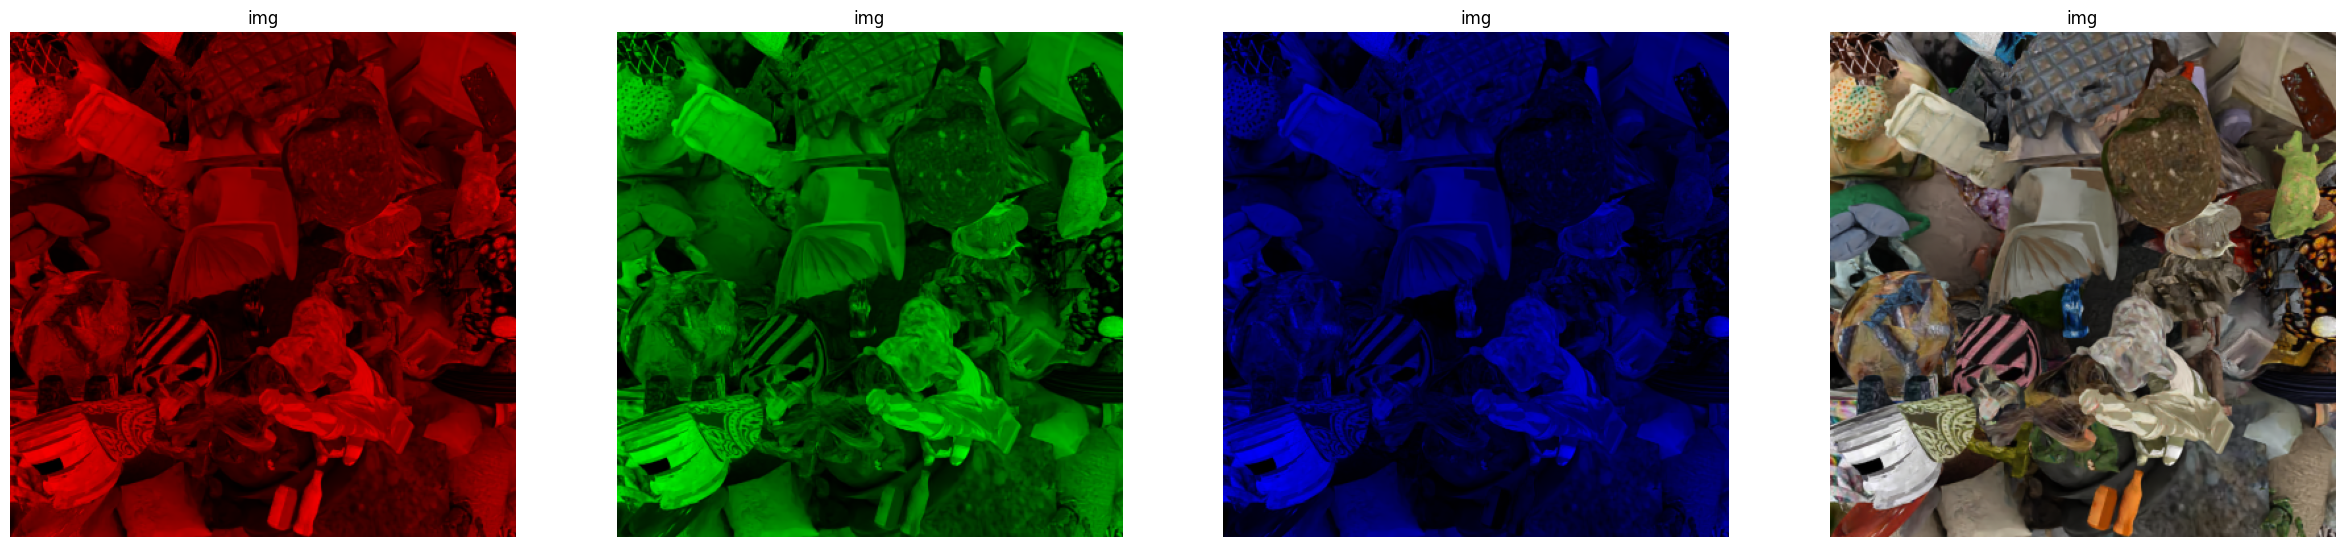

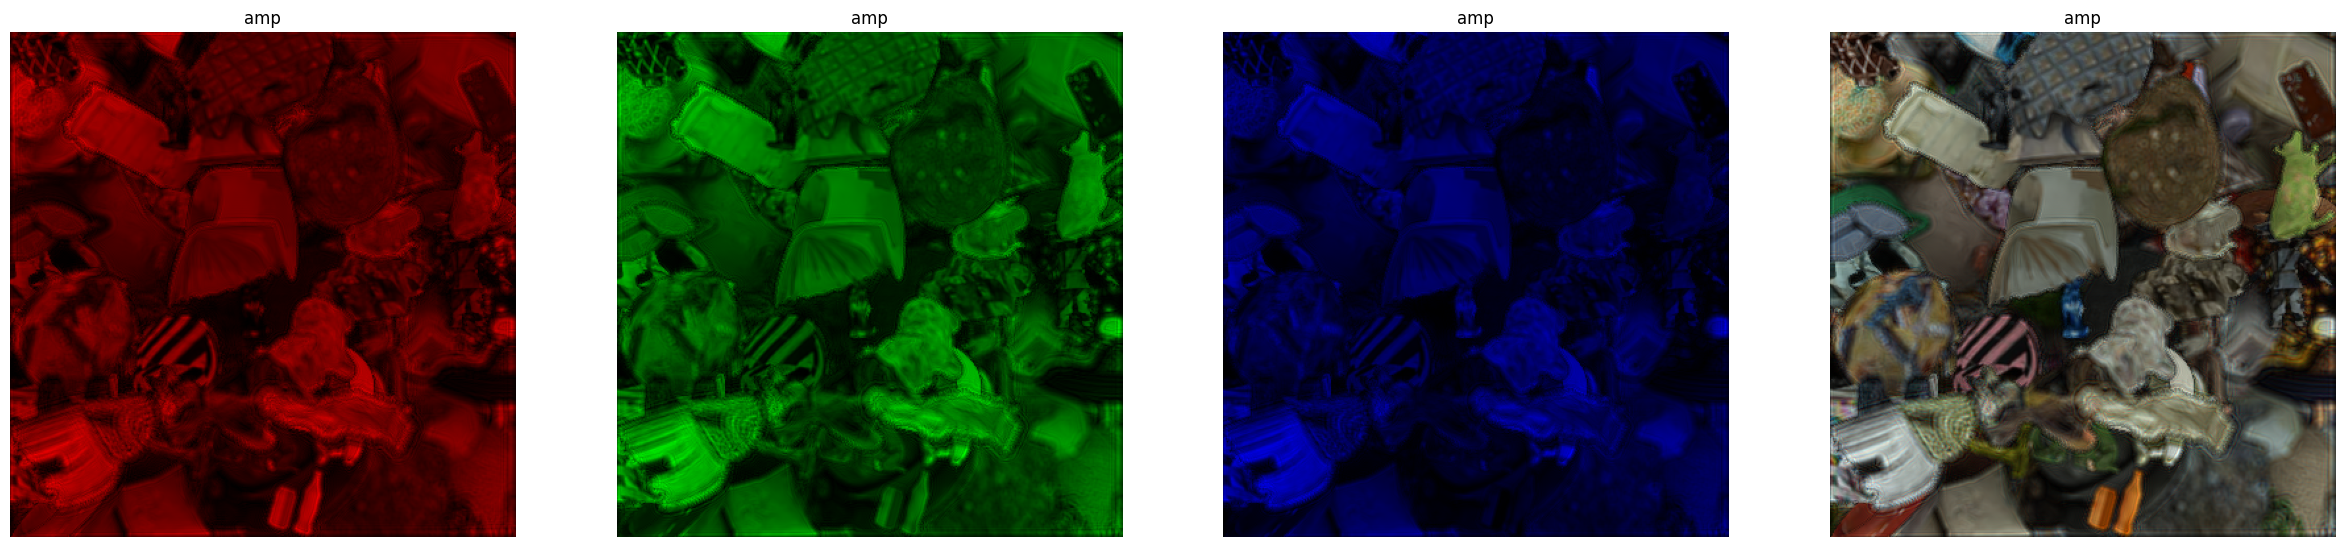

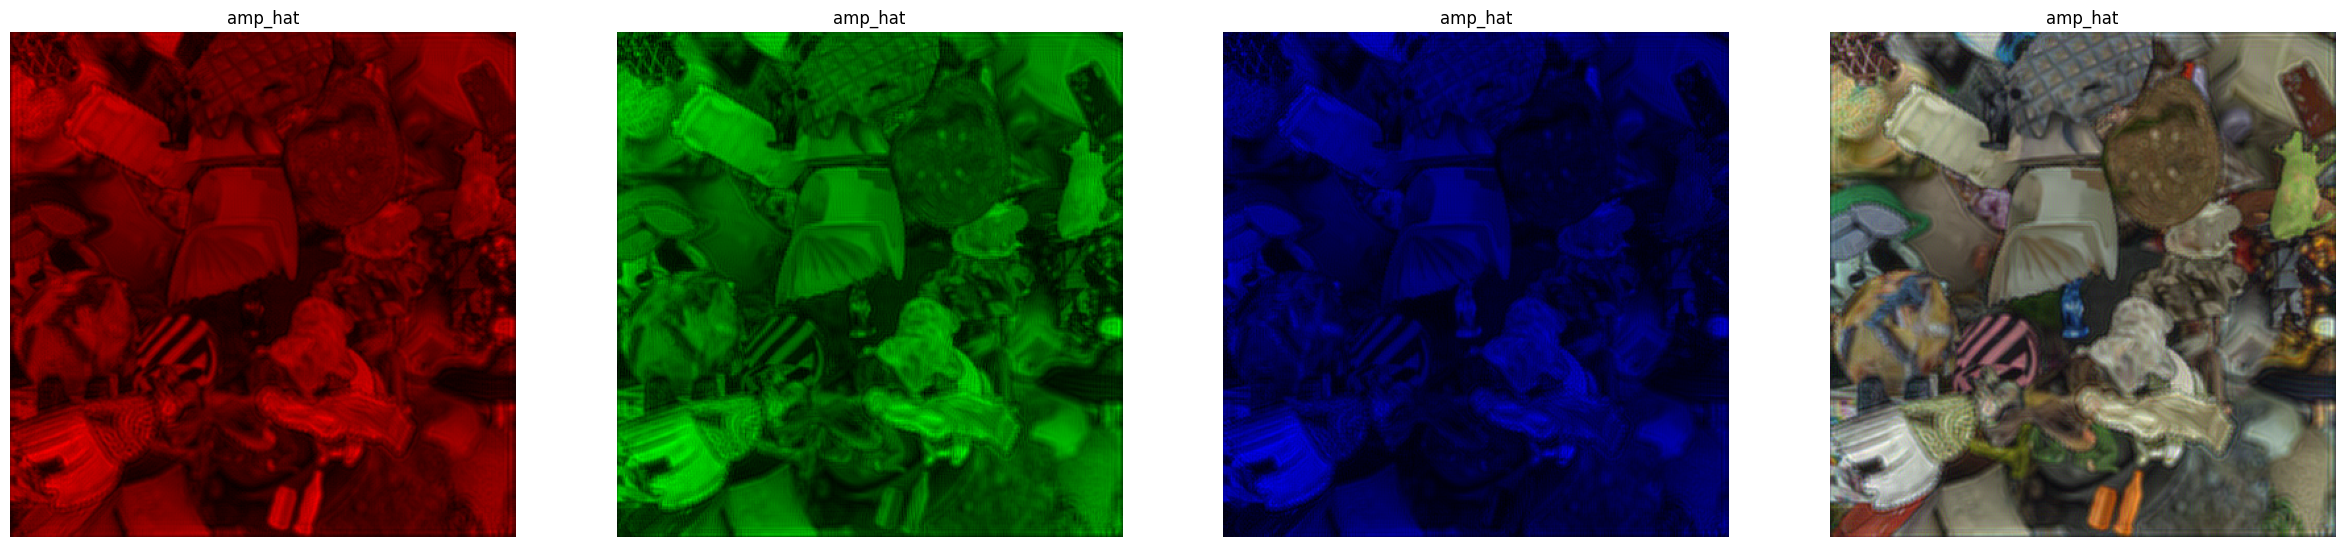

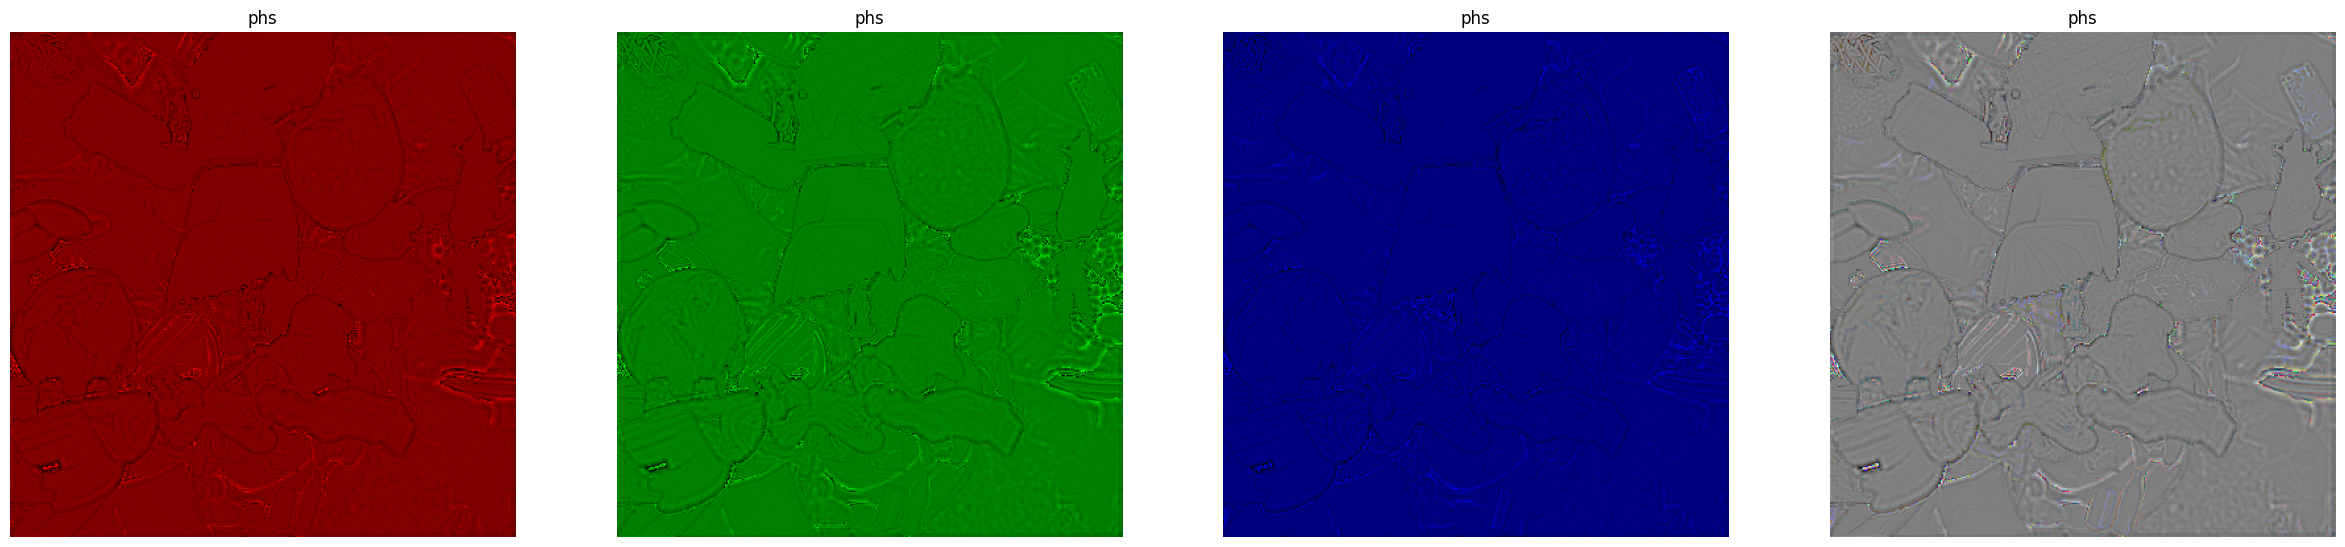

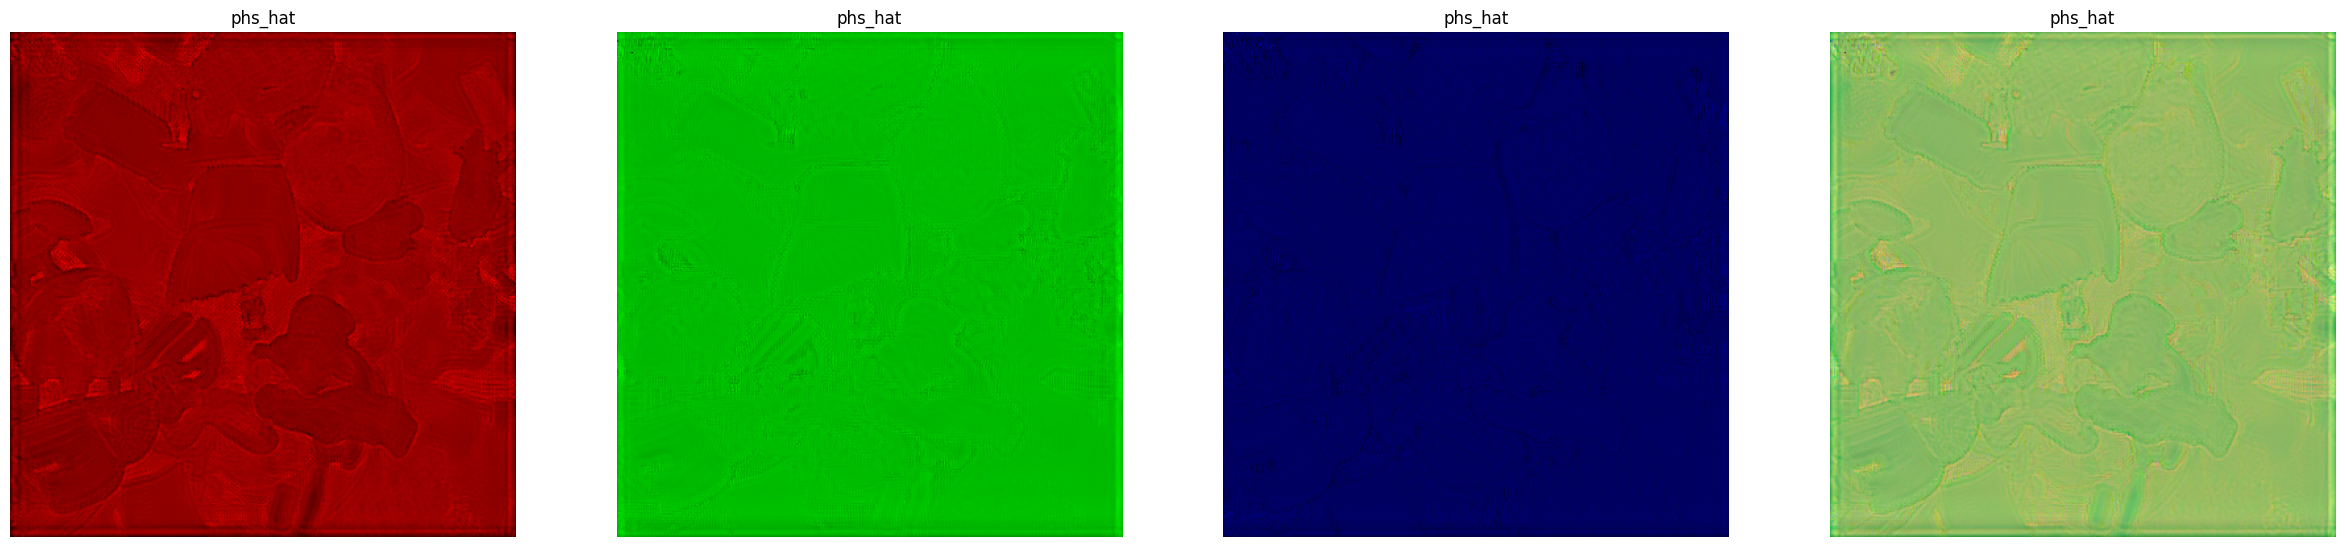

In [2]:
model_path = "output/models/watermelon_GAN_GENERATOR_E_384_epoch8.pth"

test_amp = "data/MIT_CGH_192_bin/test/amp.bin"
test_phs = "data/MIT_CGH_192_bin/test/phs.bin"
test_img = "data/MIT_CGH_192_bin/test/img.bin"
test_depth = "data/MIT_CGH_192_bin/test/depth.bin"

# validate_amp = "data/MIT_CGH_192_bin/validate/amp.bin"
# validate_phs = "data/MIT_CGH_192_bin/validate/phs.bin"
# validate_img = "data/MIT_CGH_192_bin/validate/img.bin"
# validate_depth = "data/MIT_CGH_192_bin/validate/depth.bin"

validate_amp = "data/MIT_CGH_384_bin/validate/amp.bin"
validate_phs = "data/MIT_CGH_384_bin/validate/phs.bin"
validate_img = "data/MIT_CGH_384_bin/validate/img.bin"
validate_depth = "data/MIT_CGH_384_bin/validate/depth.bin"

import torch
from learnedMethodForHologram import utilities

from learnedMethodForHologram.watermelon_GAN.data_processor import (
    data_loader_amp_phs_img_depth as data_loader,
)
from learnedMethodForHologram.watermelon_GAN.generator import Generator

from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_single_fixed_distance as BLASM_v3,
)

dataset_test = data_loader(
    img_path=validate_img,
    depth_path=validate_depth,
    amp_path=validate_amp,
    phs_path=validate_phs,
    samplesNum=100,
    channlesNum=3,
    height=384,
    width=384,
    cuda=True,
)

dataLoader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

model = Generator(
    # sample_row_num=192,
    # sample_col_num=192,
    # pad_size=416,
    sample_row_num=384,
    sample_col_num=384,
    pad_size=320,
    filter_radius_coefficient=0.45,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([638e-9, 520e-9, 450e-9]),
    distance=torch.tensor([1e-3]),
    pretrained_model_path=model_path,
    pretrained_model_path_RGBD2AP=None,
    pretrained_model_path_AP2POH=None,
)

propagator = BLASM_v3(
    # sample_row_num=192,
    # sample_col_num=192,
    # pad_size=416,
    sample_row_num=384,
    sample_col_num=384,
    pad_size=320,
    filter_radius_coefficient=0.45,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([638e-9, 520e-9, 450e-9]),
    band_limit=False,
    cuda=True,
    distance=torch.tensor([1e-3]),
)

model.eval()

with torch.no_grad():
    img_depth, amp, phs = next(iter(dataLoader_test))
    POH = model(img_depth)
    amp_hat, _ = propagator.propagate_POH2AP_forward(POH)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(
        torch.cat((img_depth[:, :-1], amp, amp_hat, phs, _ % (2 * torch.pi)), dim=0)
    ),
    titles=["img", "amp", "amp_hat", "phs", "phs_hat"],
    rgb_img=True,
    # save_dir="output\\images\\GAN\\10",
)

In [13]:
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_multiple_distances as BLASM_v4,
)

propagator_test = BLASM_v4(
    # sample_row_num=192,
    # sample_col_num=192,
    # pad_size=416,
    sample_row_num=384,
    sample_col_num=384,
    pad_size=832,
    distances=torch.linspace(-1.5e-4, 1.5e-4, 1),
    filter_radius_coefficient=0.35,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([638e-9, 520e-9, 450e-9]),
    band_limit=False,
    cuda=True,
)

amp_ones = torch.ones_like(POH).to("cuda")
amp_hat, phs_hat = propagator_test(
    amp_ones, POH, torch.linspace(1e-3 - 8e-4, 1e-3, 20)
)
amp_target, phs_target = propagator_test(
    amp, 2 * torch.pi * phs, torch.linspace(-8e-4, 0, 20)
)


utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amp_hat),
    titles=None,
    rgb_img=True,
    save_dir="output\\images\\GAN\\E_384_epoch8_amp_hat",
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amp_target),
    titles=None,
    rgb_img=True,
    save_dir="output\\images\\GAN\\E_384_epoch8_amp_target",
)

utilities.multi_sample_plotter(
    ((phs_hat + 20 * torch.pi) % (2 * torch.pi)) / (2 * torch.pi),
    titles=None,
    rgb_img=True,
    save_dir="output\\images\\GAN\\E_384_epoch8_phs_hat",
)

utilities.multi_sample_plotter(
    (phs_target + 20 * torch.pi) % (2 * torch.pi) / (2 * torch.pi),
    titles=None,
    rgb_img=True,
    save_dir="output\\images\\GAN\\E_384_epoch8_phs_target",
)

utilities.multi_sample_plotter(
    (POH + 20 * torch.pi) % (2 * torch.pi) / (2 * torch.pi),
    titles=None,
    rgb_img=True,
    save_dir="output\\images\\GAN\\E_384_epoch8_POH",
)

# print(model.part2.part1.conv_r.params[model.part2.part1.conv_r.distance_map])
# print(model.part2.part1.conv_g.params[model.part2.part1.conv_g.distance_map])
# print(model.part2.part1.conv_b.params[model.part2.part1.conv_b.distance_map])

# assessment

In [ ]:
import torch

from learnedMethodForHologram.data_processor import data_loader_A_B

test_amp = "data/MIT_CGH_192_bin/test/amp.bin"
test_phs = "data/MIT_CGH_192_bin/test/phs.bin"
test_img = "data/MIT_CGH_192_bin/test/img.bin"
test_depth = "data/MIT_CGH_192_bin/test/depth.bin"

validate_amp = "data/MIT_CGH_192_bin/validate/amp.bin"
validate_phs = "data/MIT_CGH_192_bin/validate/phs.bin"
validate_img = "data/MIT_CGH_192_bin/validate/img.bin"
validate_depth = "data/MIT_CGH_192_bin/validate/depth.bin"

train_amp = "data/MIT_CGH_192_bin/train/amp.bin"
train_phs = "data/MIT_CGH_192_bin/train/phs.bin"
train_img = "data/MIT_CGH_192_bin/train/img.bin"
train_depth = "data/MIT_CGH_192_bin/train/depth.bin"

dataset_test = data_loader_A_B(
    path_A=test_amp,
    path_B=test_phs,
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=False,
)

dataLoader_dataset_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

In [ ]:
from learnedMethodForHologram import utilities
import matplotlib.pyplot as plt
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_single_fixed_distance as BLASM_v3,
)

batch = (next(iter(dataLoader_dataset_test))).detach()
amp = batch[:, 0:3]
phs = batch[:, 3:6]

g_z = amp * torch.exp(1j * phs)
G_z = torch.fft.fft2(g_z)
filter = utilities.generate_circular_frequency_mask(
    sample_row_num=192,
    sample_col_num=192,
    radius=60,
)

# plt.imshow(filter)

G_z_filtered = G_z * filter
g_z_filtered = torch.fft.ifft2(G_z_filtered)

complex_amp = torch.abs(g_z_filtered)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(complex_amp),
    titles=None,
    rgb_img=True,
)

propagator = BLASM_v3(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
    distance=torch.tensor([1e-3]),
)

amp_phs = torch.cat((amp, phs), dim=1)
amp_phs_z = propagator.propagate_AP2AP(amp_phs)

In [ ]:
import torch
from learnedMethodForHologram.data_processor import (
    data_loader_A_B as data_loader_img_depth,
)
from learnedMethodForHologram.watermelon_v4 import watermelon_v4 as watermelon

test_amp = "data/MIT_CGH_192_bin/test/amp.bin"
test_phs = "data/MIT_CGH_192_bin/test/phs.bin"
test_img = "data/MIT_CGH_192_bin/test/img.bin"
test_depth = "data/MIT_CGH_192_bin/test/depth.bin"

validate_amp = "data/MIT_CGH_192_bin/validate/amp.bin"
validate_phs = "data/MIT_CGH_192_bin/validate/phs.bin"
validate_img = "data/MIT_CGH_192_bin/validate/img.bin"
validate_depth = "data/MIT_CGH_192_bin/validate/depth.bin"

train_amp = "data/MIT_CGH_192_bin/train/amp.bin"
train_phs = "data/MIT_CGH_192_bin/train/phs.bin"
train_img = "data/MIT_CGH_192_bin/train/img.bin"
train_depth = "data/MIT_CGH_192_bin/train/depth.bin"

model = watermelon(
    input_shape=(4, 4, 192, 192),
    perceptual_model_path="output/models/perceptual_loss_watermelon_v4.pth",
    propagation_distance=torch.tensor([1e-3]),
    cuda=False,
)

model.load_state_dict(torch.load("output/models/watermelon_v4_0.pth"))
model.eval()

dataset_test = data_loader_img_depth(
    path_A="data/MIT_CGH_192_bin/test/img.bin",
    path_B="data/MIT_CGH_192_bin/test/depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=False,
)

dataLoader_dataset_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

In [ ]:
from learnedMethodForHologram import utilities

batch = (next(iter(dataLoader_dataset_test))).detach()
amp_phs_z = model.part1(batch).detach()
amp_phs_0 = model.propagator.propagate_AP2AP(amp_phs_z).detach()
phs_0 = model.part2(amp_phs_0).detach()
amp_amp_phs = model.propagator.propagate_P2AAP(phs_0).detach()
intensity = ((amp_amp_phs[:, :3]) ** 2).detach()
input_phs_restruction = torch.cat((batch[:, :3], phs_0, intensity), dim=0)

amp = amp_amp_phs[:, 3:6]
phs = amp_amp_phs[:, 6:9]

g_z = amp * torch.exp(1j * phs)
G_z = torch.fft.fft2(g_z)
filter = utilities.generate_circular_frequency_mask(
    sample_row_num=192,
    sample_col_num=192,
    radius=60,
)
G_z_filtered = G_z * filter
g_z_filtered = torch.fft.ifft2(G_z_filtered)
input_phs_restruction_filtered = torch.cat(
    (batch[:, :3], torch.abs(g_z_filtered) ** 2), dim=0
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(input_phs_restruction),
    titles=[
        "ground_truth_at_z1_v4",
        "POH_at_z0_v4",
        "reconstructed_intensity_at_z1_v4",
    ],
    rgb_img=True,
    # save_dir="/content"
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(input_phs_restruction_filtered),
    titles=[
        "ground_truth",
        "reconstructed_intensity_filtered",
    ],
    rgb_img=True,
    # save_dir="/content"
)

## padding

In [ ]:
import torch

from learnedMethodForHologram import utilities
from learnedMethodForHologram.data_processor import data_loader

from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod as BLASM_v2,
)

from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_single_fixed_distance as BLASM_v3,
)

from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_multiple_distances as BLASM_v4,
)

propagator = BLASM_v2(
    sample_row_num=192,
    sample_col_num=192,
    pad_size=196,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([450e-9, 520e-9, 638e-9]),
    band_limit=False,
    cuda=False,
)

propagator_hat = BLASM_v3(
    sample_row_num=192,
    sample_col_num=192,
    pad_size=196,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([450e-9, 520e-9, 638e-9]),
    band_limit=False,
    cuda=False,
    distance=torch.tensor([2.5e-2]),
)

propagator_hat_1 = BLASM_v4(
    sample_row_num=192,
    sample_col_num=192,
    pad_size=196,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([450e-9, 520e-9, 638e-9]),
    band_limit=False,
    cuda=False,
)


dataset = data_loader(
    "data/MIT_CGH_192_bin/test/amp.bin",
    "data/MIT_CGH_192_bin/test/phs.bin",
    "data/MIT_CGH_192_bin/test/img.bin",
    "data/MIT_CGH_192_bin/test/depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=False,
)

data = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=0)
amp, phs, img, depth = next(iter(data))

amp_phs_z_0_filtered = torch.fft.ifft2(
    torch.fft.fft2(amp * torch.exp(1j * phs * 2 * torch.pi))
    # * utilities.generate_circular_frequency_mask(192, 192, 96)
)

amp_phs_z_0_filtered_propagateed_hat = propagator_hat(
    amp,
    (phs * 2 * torch.pi),
)


utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amp_phs_z_0_filtered_propagateed_hat),
    titles=None,
    rgb_img=True,
)

# utilities.multi_sample_plotter(
#     utilities.tensor_normalizor_2D(torch.stack((img, depth, amp, phs), dim=0)),
#     titles=None,
#     rgb_img=True,
# )

amp, phs, img, depth = dataset[0]
print(amp.shape, phs.shape, img.shape, depth.shape)


data = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=0)
amp, phs, img, depth = next(iter(data))

amp_phs_z_0_filtered_propagateed = propagator(
    amp,
    phs * 2 * torch.pi,
    # distances=torch.linspace(-3e-4, 3e-4, 20),
    distances=torch.tensor([2.5e-2, 0]),
)
print(amp_phs_z_0_filtered_propagateed.shape)

utilities.multi_sample_plotter(
    # utilities.tensor_normalizor_2D(torch.sqrt(amp_phs_z_0_filtered_propagateed)),
    utilities.tensor_normalizor_2D(amp_phs_z_0_filtered_propagateed),
    titles=None,
    rgb_img=True,
    # save_dir="output\\test_output\\focus_test_padding196_radius96_distance-3e-4_3e-4_20",
)


data = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=False, num_workers=0)
amp, phs, img, depth = next(iter(data))

amp_phs_z_0_filtered_propagateed = propagator_hat_1(
    amp,
    phs * 2 * torch.pi,
    # distances=torch.linspace(-3e-4, 3e-4, 20),
    distances=torch.tensor([2.5e-2, 0]),
)
print(amp_phs_z_0_filtered_propagateed.shape)

# utilities.multi_sample_plotter(
#     # utilities.tensor_normalizor_2D(torch.sqrt(amp_phs_z_0_filtered_propagateed)),
#     utilities.tensor_normalizor_2D(amp_phs_z_0_filtered_propagateed),
#     titles=None,
#     rgb_img=True,
#     # save_dir="output\\test_output\\focus_test_padding196_radius96_distance-3e-4_3e-4_20",
# )

In [ ]:
import torch

from learnedMethodForHologram import utilities
from learnedMethodForHologram.data_processor import data_loader

from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod as BLASM_v2,
)

from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_single_fixed_distance as BLASM_v3,
)

propagator = BLASM_v2(
    sample_row_num=192,
    sample_col_num=192,
    pad_size=0,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([450e-9, 520e-9, 638e-9]),
    band_limit=False,
    cuda=False,
)

dataset = data_loader(
    "data/MIT_CGH_192_bin/test/amp.bin",
    "data/MIT_CGH_192_bin/test/phs.bin",
    "data/MIT_CGH_192_bin/test/img.bin",
    "data/MIT_CGH_192_bin/test/depth.bin",
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=False,
)

amp, phs, img, depth = dataset[0]

amp_phs_z_0 = torch.cat((amp, phs), dim=0).unsqueeze(0)
print(amp_phs_z_0.shape)

amp_phs_z_0_filtered = torch.fft.ifft2(
    torch.fft.fft2(amp_phs_z_0[:, :3] * torch.exp(1j * amp_phs_z_0[:, 3:]))
    # * utilities.generate_circular_frequency_mask(192, 192, 96)
)

amp_phs_z_0_filtered_propagateed = propagator(
    amp_phs_z_0[:, :3],
    amp_phs_z_0[:, 3:],
    distances=torch.linspace(0, 1e-5, 7),
)
print(torch.linspace(0, 1e-5, 7))
utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(torch.sqrt(amp_phs_z_0_filtered_propagateed)),
    titles=None,
    rgb_img=True,
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(
        torch.log(
            torch.abs(
                torch.fft.fftshift(torch.fft.fft2(amp_phs_z_0_filtered), dim=(-1, -2))
            )
            + 1
        )
    ),
    titles=None,
    rgb_img=True,
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(torch.abs(amp_phs_z_0_filtered)),
    titles=None,
    rgb_img=True,
)

real_signal_spectrum = torch.fft.fftshift(
    torch.fft.fft(torch.abs(amp_phs_z_0_filtered) ** 2)
)
utilities.multi_channel_plotter(
    torch.abs(real_signal_spectrum),
    title="real_signal_spectrum",
    color=2,
)

In [ ]:
from learnedMethodForHologram import utilities
import matplotlib.pyplot as plt
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_single_fixed_distance as BLASM_v3,
)

propagator = BLASM_v3(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
    distance=torch.tensor([10e-5]),
)

amp_phs_z_0 = amp_amp_phs[:, 3:]
amp_phs_z_0_filtered = torch.fft.ifft2(
    torch.fft.fft2(amp_phs_z_0[:, :3] * torch.exp(1j * amp_phs_z_0[:, 3:]))
    * utilities.generate_circular_frequency_mask(192, 192, 60)
)

# amp_phs_z_1 = propagator.propagate_AP2AP(amp_phs_z_0)
# amp_phs_z_1_filtered = torch.fft.ifft2(
#     torch.fft.fft2(amp_phs_z_1[:, :3] * torch.exp(1j * amp_phs_z_1[:, 3:]))
#     * utilities.generate_circular_frequency_mask(192, 192, 20)
# )
amp_phs_z_1 = propagator(amp_phs_z_0[:, :3], amp_phs_z_0[:, 3:])


intensity_comparison = torch.cat(
    # ((amp_phs_z_0[:, :3]) ** 2, (amp_phs_z_1[:, :3]) ** 2), dim=0
    ((amp_phs_z_0[:, :3]) ** 2, (amp_phs_z_1[:, :3])),
    dim=0,
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(intensity_comparison),
    titles=None,
    rgb_img=True,
)

intensity_comparison_filtered = torch.cat(
    (
        # torch.abs(amp_phs_z_0_filtered) ** 2,
        # torch.abs(amp_phs_z_1_filtered) ** 2,
        torch.abs(amp_phs_z_0_filtered) ** 2,
        amp_phs_z_1,
    ),
    dim=0,
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(intensity_comparison_filtered),
    titles=None,
    rgb_img=True,
)

phssss = amp_amp_phs[:, 6:]

phs_filtered = torch.fft.ifft2(
    torch.fft.fft2(amp_amp_phs[:, 3:6] * torch.exp(1j * phssss))
    * utilities.generate_circular_frequency_mask(192, 192, 60)
)

phs_filtered = torch.angle(phs_filtered)
mask = phs_filtered < 0
phs_filtered[mask] = phs_filtered[mask] + 2 * torch.pi

utilities.multi_sample_plotter(
    phs_filtered / (2 * torch.pi),
    titles=None,
    rgb_img=True,
)

print(f"amp_phs_z_0 max: {amp_amp_phs[:,6:].max()}")
print(f"amp_phs_z_0 min: {amp_amp_phs[:,6:].min()}")

print(f"amp_phs_z_0 max: {(amp_amp_phs[:,6:]/(2*torch.pi)+0.5).max()}")
print(f"amp_phs_z_0 min: {(amp_amp_phs[:,6:]/(2*torch.pi)+0.5).min()}")

# ground truth

In [ ]:
import torch

from learnedMethodForHologram.data_processor import data_loader
from learnedMethodForHologram import utilities

from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_single_fixed_distance as BLASM_v3,
)

test_amp = "data/MIT_CGH_192_bin/test/amp.bin"
test_phs = "data/MIT_CGH_192_bin/test/phs.bin"
test_img = "data/MIT_CGH_192_bin/test/img.bin"
test_depth = "data/MIT_CGH_192_bin/test/depth.bin"

from learnedMethodForHologram.data_processor import data_loader_for_percepetual_loss

data_loader = data_loader_for_percepetual_loss(
    test_amp,
    test_phs,
    test_depth,
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=False,
)

dataLoader = torch.utils.data.DataLoader(
    data_loader,
    batch_size=1,
    shuffle=False,
    num_workers=0,
)

amp_phs_z_0 = next(iter(dataLoader))
print(f"amp_phs_z_0 shape: {amp_phs_z_0.shape}")

propagator = BLASM_v3(
    sample_row_num=192,
    sample_col_num=192,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=False,
    distance=torch.tensor([-1e-4]),
)

amp_phs_z_1 = propagator(amp_phs_z_0[:, :3], amp_phs_z_0[:, 3:6])

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amp_phs_z_1),
    titles=None,
    rgb_img=True,
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amp_phs_z_0[:, 3:6]),
    titles=None,
    rgb_img=True,
)

print(f"amp_phs_z_1 max: {amp_phs_z_0[:, 3:6].max()}")
print(f"amp_phs_z_1 min: {amp_phs_z_0[:, 3:6].min()}")

phs_filtered = torch.fft.ifft2(
    torch.fft.fft2(amp_phs_z_0[:, :3] * torch.exp(1j * amp_phs_z_0[:, 3:6]))
    * utilities.generate_circular_frequency_mask(192, 192, 96)
)

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(torch.angle(phs_filtered)),
    titles=None,
    rgb_img=True,
)

# drafts

In [ ]:
import torch

from learnedMethodForHologram.data_processor import data_loader
from learnedMethodForHologram import utilities

test_amp = "data/MIT_CGH_192_bin/test/amp.bin"
test_phs = "data/MIT_CGH_192_bin/test/phs.bin"
test_img = "data/MIT_CGH_192_bin/test/img.bin"
test_depth = "data/MIT_CGH_192_bin/test/depth.bin"

validate_amp = "data/MIT_CGH_192_bin/validate/amp.bin"
validate_phs = "data/MIT_CGH_192_bin/validate/phs.bin"
validate_img = "data/MIT_CGH_192_bin/validate/img.bin"
validate_depth = "data/MIT_CGH_192_bin/validate/depth.bin"

train_amp = "data/MIT_CGH_192_bin/train/amp.bin"
train_phs = "data/MIT_CGH_192_bin/train/phs.bin"
train_img = "data/MIT_CGH_192_bin/train/img.bin"
train_depth = "data/MIT_CGH_192_bin/train/depth.bin"

dataset_test = data_loader(
    test_amp,
    test_phs,
    test_img,
    test_depth,
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
)

amp, phs, img, depth = dataset_test[0]
# utilities.multi_sample_plotter(
#     torch.stack((amp, phs, img, depth), dim=0),
#     titles=None,
#     rgb_img=True,
# )

print(f"max in amp: {amp.max()}")
print(f"min in amp: {amp.min()}")

print(f"max in img: {img.max()}")
print(f"min in img: {img.min()}")

torch.nn.MSELoss()((amp[0]) ** 2, img[0])

In [6]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# 示例使用
# 输入通道数为3，输出通道数为64
model = DoubleConv(3, 64)
input_tensor = torch.randn(1, 3, 256, 256)  # 批次大小为1，输入通道为3，图像大小为256x256
output_tensor = model(input_tensor)
print(output_tensor.shape)  # 输出张量的形状


torch.Size([1, 64, 256, 256])


In [ ]:
import matplotlib.pyplot as plt

tensor1 = amp[0] * torch.exp(1j * phs[0])
tensor1_spectrum = torch.abs(torch.fft.fftshift(torch.fft.fft2(tensor1), dim=(-2, -1)))
tensor2 = img[0] * torch.exp(1j * phs[0])
tensor2_spectrum = torch.abs(torch.fft.fftshift(torch.fft.fft2(tensor2), dim=(-2, -1)))

plt.imshow(torch.log(tensor1_spectrum + 1.0))
plt.title("the log spectrum of the amplitude")
plt.colorbar()
plt.show()

plt.imshow(torch.log(tensor2_spectrum + 1.0))
plt.title("the log spectrum of the image")
plt.colorbar()
plt.show()

plt.imshow(tensor1_spectrum - tensor2_spectrum)
plt.title("the difference in spectrum")
plt.colorbar()
plt.show()

mask = (-1e-1 < (tensor1_spectrum / tensor2_spectrum - 1)) & (
    (tensor1_spectrum / tensor2_spectrum - 1) < 0
)
# which means the amplitude is larger than the image

plt.imshow(mask)
plt.title("mask")
plt.colorbar()
plt.show()

torch.nn.MSELoss()(tensor1_spectrum, tensor2_spectrum)

In [ ]:
sample_row_num = 2400
sample_col_num = 4094
x = sample_row_num // 3
y = x * sample_col_num // sample_row_num
x, y

In [ ]:
tensorX = torch.rand(3, 5, 256, 256)
tensor_192 = tensorX[
    ...,
    256 // 2 - 192 // 2 : 256 // 2 + 192 // 2,
    256 // 2 - 192 // 2 : 256 // 2 + 192 // 2,
]
print(tensor_192.shape)

In [ ]:
import torch
from learnedMethodForHologram import utilities
tensorX = torch.rand(3,5,256,256)
%timeit utilities.cut_center_256_192(tensorX).shape

In [ ]:
import torch

# 创建一个张量并启用梯度计算
x = torch.tensor(
    [[1.0, 2.0, 3.0], [3.0, 4.0, 5.0], [4.0, 5.0, 6.0]], requires_grad=True
)

# 对张量进行裁剪，并将裁剪的部分分离出计算图
y = x[:1, :].detach()

# 进行一些计算
z = y.sum() + x.sum()

# 反向传播
z.backward()

# 查看梯度
print(y.grad)  # 只有没有被分离的部分会有梯度

In [ ]:
import torch

# 创建一个张量并启用梯度计算
x = torch.tensor([[1.0, 2.0], [3.0, 4.0]], requires_grad=True)

# 对张量进行裁剪，并将裁剪的部分分离出计算图
x = x[:1, :]
x.retain_grad()

# 进行一些计算
z = x.sum()

# 反向传播
z.backward()

# 查看梯度
print(x.grad)  # 只有没有被分离的部分会有梯度

In [ ]:
import torch

# 假设的行数和列数
samplingRowNum = 10
samplingColNum = 20

# 示例张量，假设形状为 (100, 3, 2, 10, 20)
amp_phs_tensor = torch.randn(100, 6, samplingRowNum, samplingColNum)

# 重新定义形状，并去除大小为1的维度
result_tensor = amp_phs_tensor.view(-1, 3, 2, samplingRowNum, samplingColNum)[
    :, :, 0
].squeeze()

print(result_tensor.shape)

In [ ]:
import torch


def custom_loss(output, target):
    # 计算每个像素的绝对差异
    loss = torch.mean(torch.abs(output - target))
    return loss


# 假设 batch_num 为 x，图像大小为 192x192，三通道
batch_num = 4
output = torch.randn(batch_num, 3, 192, 192)  # 模型输出
target = torch.randn(batch_num, 3, 192, 192)  # 目标图像

# 计算自定义损失
loss = custom_loss(output, target)
print(f"Custom Loss: {loss.item()}")

In [ ]:
x = torch.randn(4, 3, 192, 192)
y = x[:, :2]
print(y.shape)

In [ ]:
import numpy as np

# 生成示例复光场数据（这里只是一个示例，不是实际数据）
# 复光场数据通常是一个 4D 数组，包含振幅和相位信息
L = np.random.rand(100, 100, 100, 100) + 1j * np.random.rand(100, 100, 100, 100)


# 提取特定视角的信息
def extract_view(L, angle_u, angle_v):
    # 对复光场数据进行傅里叶变换
    L_ft = np.fft.fftshift(np.fft.fft2(L, axes=(0, 1)))

    # 选择特定角度的视角
    u_index = int((L.shape[0] / 2) + angle_u * (L.shape[0] / 2))
    v_index = int((L.shape[1] / 2) + angle_v * (L.shape[1] / 2))

    # 提取该视角下的图像信息
    view = L_ft[u_index, v_index, :, :]

    # 对提取的视角图像进行逆傅里叶变换
    view_image = np.fft.ifft2(np.fft.ifftshift(view))

    return np.abs(view_image)


import matplotlib.pyplot as plt

# 提取不同角度的视角图像
angle_u, angle_v = 0.1, 0.2  # 示例角度
view_image = extract_view(L, angle_u, angle_v)

# 显示视角图像（这里省略具体显示代码，使用 matplotlib 或其他图像显示库）
plt.imshow(view_image, cmap="gray")
plt.title(f"View at angles ({angle_u}, {angle_v})")
plt.show()

# 提取不同角度的视角图像
angle_u, angle_v = -0.1, -0.2  # 示例角度
view_image = extract_view(L, angle_u, angle_v)

# 显示视角图像（这里省略具体显示代码，使用 matplotlib 或其他图像显示库）
plt.imshow(view_image, cmap="gray")
plt.title(f"View at angles ({angle_u}, {angle_v})")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 假设生成器和判别器已经定义
generator = Generator()
discriminator = Discriminator()

# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

# 假设 dataloader 是一个提供批量数据的迭代器
for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):

        # 获取当前批次大小
        batch_size = real_images.size(0)

        # 真实数据标签为1，生成数据标签为0
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)

        # ---------------------
        # 训练判别器
        # ---------------------

        # 训练真实数据
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)

        # 训练生成数据
        z = torch.randn(batch_size, z_dim)
        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        # 总的判别器损失
        d_loss = d_loss_real + d_loss_fake
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # ---------------------
        # 训练生成器
        # ---------------------

        # 生成数据，期望判别器输出为真实
        z = torch.randn(batch_size, z_dim)
        fake_images = generator(z)
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    print(
        f"Epoch [{epoch+1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}"
    )

## some exploration in the frequency domain

In [ ]:
import torch
from learnedMethodForHologram.data_processor import data_loader_A_B

dataset_train = data_loader_A_B(
    path_A="data/MIT_CGH_192_bin/train/img.bin",
    path_B="data/MIT_CGH_192_bin/train/depth.bin",
    samplesNum=3800,
    channlesNum=3,
    height=192,
    width=192,
    cuda=False,
)

In [ ]:
from learnedMethodForHologram import utilities
import matplotlib.pyplot as plt

img_spatial_domain = torch.sqrt(dataset_train[0][0:3])
utilities.multi_channel_plotter(
    utilities.tensor_normalizor_2D(dataset_train[0][0:3]),
    title="image in spatial domain",
    # save_dir="output\images\lowpass_compare",
)

img_freq_domain = torch.fft.fftshift(torch.fft.fft2(img_spatial_domain), dim=(-1, -2))
img_freq_domain_amp = torch.abs(img_freq_domain)
img_freq_domain_phs = torch.angle(img_freq_domain)
img_freq_domain_amp_log = torch.log(img_freq_domain_amp)
utilities.multi_channel_plotter(
    utilities.tensor_normalizor_2D(img_freq_domain_amp_log),
    title="log amplitude in frequency domain(normalized)",
)
utilities.multi_channel_plotter(
    utilities.tensor_normalizor_2D(img_freq_domain_phs),
    title="phase in frequency domain",
)
print(f"the max value of the phs is {img_freq_domain_phs.max()}")
print(f"the min value of the phs is {img_freq_domain_phs.min()}")

# for i in range(3):
#     plt.imshow(img_freq_domain_amp_log[i].numpy())
#     plt.colorbar()
#     plt.title(f"channel {i}")
#     plt.show()

mask = torch.fft.fftshift(utilities.generate_circular_frequency_mask(192, 192, 60))
masked_img_freq_domain = img_freq_domain * mask
masked_img_freq_domain_amp = img_freq_domain_amp_log * mask

utilities.multi_channel_plotter(
    utilities.tensor_normalizor_2D(masked_img_freq_domain_amp),
    title="amplitude in frequency domain after filtering",
)

masked_img_spatial_domain = torch.fft.ifft2(
    torch.fft.ifftshift(masked_img_freq_domain, dim=(-1, -2))
)

masked_img_spatial_domain_amp = torch.abs(masked_img_spatial_domain) ** 2

utilities.multi_channel_plotter(
    utilities.tensor_normalizor_2D(masked_img_spatial_domain_amp),
    title="amplitude in frequency domain of ground truth",
    # save_dir="output\images\lowpass_compare",
)

masked_img_spatial_domain_img = torch.abs(masked_img_spatial_domain) ** 2

utilities.multi_channel_plotter(
    utilities.tensor_normalizor_2D(masked_img_spatial_domain_img),
    title="image in spatial domain after filtering",
    # save_dir="output\images\lowpass_compare",
)

In [ ]:
from learnedMethodForHologram import utilities
import matplotlib.pyplot as plt

import torch

mask = utilities.generate_circular_frequency_mask(192, 192, 60)
print(mask[mask == 1.0].shape)

mask = torch.fft.fftshift(mask)
plt.imshow(mask)
plt.colorbar()
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from learnedMethodForHologram import utilities


def generate_circle_frequency_mask(
    sample_row_num=192,
    sample_col_num=192,
    radius=60,
    decay_rate=None,
):
    shorter_edge = min(sample_row_num, sample_col_num)
    if radius > shorter_edge / 2:
        raise ValueError(
            f"The radius {radius} is larger than the half of the sample size {shorter_edge/2}"
        )

    # Create a grid of (u, v) coordinates
    u = torch.fft.fftfreq(sample_row_num).unsqueeze(-1)
    v = torch.fft.fftfreq(sample_col_num).unsqueeze(0)
    # enable the circle change to ellipse
    D = torch.sqrt(u**2 + v**2) * shorter_edge

    mask = torch.ones_like(D)
    if decay_rate is not None:
        # Create the circular low-pass filter with exponential decay around the radius
        mask[D > radius] = torch.exp(-decay_rate * (D[D > radius] - radius))
    else:
        mask[D > radius] = 0.0

    return mask


filter1 = generate_circle_frequency_mask()
filter2 = utilities.generate_circular_frequency_mask(192, 192, 60)
assert torch.allclose(filter1, filter2)

filter = torch.fft.fftshift(filter2)
plt.imshow(filter)
plt.colorbar()
plt.title("Filter kernel")
plt.show()

cut = filter[95, :]
plt.plot(cut)
plt.title("Filter kernel cut")
plt.show()

plt.plot(torch.log(cut))
plt.title("Filter kernel cut")
plt.show()

In [ ]:
n = 12
torch.fft.fftfreq(n, 1) * n

In [ ]:
torch.fft.fftfreq(100, 1)

In [ ]:
from learnedMethodForHologram import utilities

mask_1 = utilities.generate_checkerboard_mask(10, 10, reversed=False)
mask_2 = utilities.generate_checkerboard_mask(10, 10, reversed=True)

import matplotlib.pyplot as plt

plt.imshow(mask_1)
plt.colorbar()
plt.show()

plt.imshow(mask_2)
plt.colorbar()
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt


def double_phase_encoding(amplitude, phase):
    """
    Encode a complex hologram into a phase-only hologram using the double phase method.

    Parameters:
        amplitude (torch.Tensor): Normalized amplitude (0 <= A <= 1).
        phase (torch.Tensor): Phase.

    Returns:
        combined_phase (torch.Tensor): Phase-only hologram in checkerboard pattern.
    """
    # Step 1: Compute phi1 and phi2
    phi1 = phase - torch.acos(amplitude)
    phi2 = phase + torch.acos(amplitude)

    # Step 2: Discard every other pixel along one spatial axis
    amplitude_discarded = amplitude[:, ::2]
    phi1_discarded = phi1[:, ::2]
    phi2_discarded = phi2[:, ::2]

    # Step 3: Create checkerboard pattern
    N, M = amplitude_discarded.shape
    checkerboard = np.indices((N, M)).sum(axis=0) % 2
    checkerboard = torch.from_numpy(checkerboard)

    # Step 4: Initialize the combined phase tensor
    hologram1 = 0.5 * torch.exp(1j * phi1_discarded)
    hologram2 = 0.5 * torch.exp(1j * phi2_discarded)
    combined_phase = torch.zeros((N, M), dtype=torch.complex64)
    combined_phase[checkerboard == 0] = hologram1[checkerboard == 0]
    combined_phase[checkerboard == 1] = hologram2[checkerboard == 1]

    return combined_phase


# Example usage
N = 10
A = torch.rand(N, N)
phi = torch.rand(N, N) * 2 * np.pi

combined_phase = double_phase_encoding(A, phi)

# Convert to numpy for plotting
combined_phase_np = combined_phase.numpy()

# Plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Phase Hologram 1")
plt.imshow(np.angle(torch.exp(1j * (phi - torch.acos(A)))[:, ::2].numpy()), cmap="gray")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Phase Hologram 2")
plt.imshow(np.angle(torch.exp(1j * (phi + torch.acos(A)))[:, ::2].numpy()), cmap="gray")
plt.colorbar()

plt.figure(figsize=(5, 5))
plt.title("Checkerboard Combined Phase")
plt.imshow(np.angle(combined_phase_np), cmap="gray")
plt.colorbar()

plt.show()

In [ ]:
import numpy as np
import torch


def generate_checkerboard_mask(height, width, cell_size):
    # 使用NumPy生成棋盘格掩码
    x = np.arange(width).reshape(1, -1) // cell_size
    y = np.arange(height).reshape(-1, 1) // cell_size
    checkerboard_np = (x + y) % 2
    checkerboard_np = checkerboard_np.astype(np.float32)

    # 将NumPy数组转换为PyTorch张量
    checkerboard_torch = torch.tensor(checkerboard_np)

    return checkerboard_torch


# 示例用法
height = 10
width = 10
cell_size = 3

mask = generate_checkerboard_mask(height, width, cell_size)
print(mask)

In [ ]:
import torch

u = torch.fft.fftfreq(1920).unsqueeze(-1)
v = torch.fft.fftfreq(1920).unsqueeze(0)
D1 = torch.sqrt(u**2 + v**2) * 1920

import learnedMethodForHologram.utilities as utilities

D = utilities.prepare_circular_frequency_mask_differentiable_grid(1920, 1920)

import matplotlib.pyplot as plt

plt.imshow(D)
plt.colorbar()
plt.show()

In [ ]:
shorter_edge = min(1920, 1920)
radius = shorter_edge * 0.3
mask = torch.sigmoid(10 * (radius - D))

import matplotlib.pyplot as plt

plt.imshow(mask)
plt.colorbar()
plt.show()

In [ ]:
sample_row_num = 96
sample_col_num = 192
pad_size = 2

samplingRowNum = sample_row_num + 2 * pad_size
samplingColNum = sample_col_num + 2 * pad_size * (sample_col_num // sample_row_num)

print(samplingRowNum, samplingColNum)

In [ ]:
test_amp = "data/MIT_CGH_192_bin/test/amp.bin"
test_phs = "data/MIT_CGH_192_bin/test/phs.bin"

In [ ]:
import torch
from learnedMethodForHologram.watermelon_GAN.data_processor import (
    data_loader_amp_2PIphs as data_loader,
)
from learnedMethodForHologram.watermelon_GAN.AP2POH import AP2POH

from learnedMethodForHologram import utilities

dataset_test = data_loader(
    amp_path=test_amp,
    phs_path=test_phs,
    samplesNum=100,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=2,
    shuffle=False,
    num_workers=0,
)

amp_z, phs_z = next(iter(dataLoader_test))

In [ ]:
import torch
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_multiple_distances as BLASM_v4,
)

propagator = BLASM_v4(
    sample_row_num=192,
    sample_col_num=192,
    pad_size=196,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([638e-9, 520e-9, 450e-9]),
    band_limit=False,
    cuda=True,
)

distances = torch.linspace(-1.5e-4, 0, 7)
amps = propagator(amp_z, phs_z, distances)
amps.shape

utilities.multi_sample_plotter(
    utilities.tensor_normalizor_2D(amps.view(-1, 3, 192, 192)),
    titles=None,
    rgb_img=True,
)

In [ ]:
from learnedMethodForHologram.watermelon_GAN.loss_func import perceptual_loss

x_hat = torch.randn(2, 3, 192, 192).to("cuda")
x = torch.randn(2, 3, 192, 192).to("cuda")

loss = perceptual_loss()
loss(x_hat, x)

In [ ]:
# Example usage:
import torch
from learnedMethodForHologram.watermelon_GAN.discriminator import WGANGPDiscriminator192

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
discriminator = WGANGPDiscriminator192(feature_d=64).to(device)
img = torch.randn((8, 3, 192, 192)).to(
    device
)  # Batch of 8 images, 3 channels, 192x192 size
output = discriminator(img)
print(output.shape)  # should print: torch.Size([8])

In [ ]:
import torch
from learnedMethodForHologram.utilities import generate_circular_frequency_mask_modified

mask = generate_circular_frequency_mask_modified(192, 192, 0.3)

import matplotlib.pyplot as plt

plt.imshow(mask)
plt.colorbar()
plt.show()

In [ ]:
from learnedMethodForHologram.bandlimited_angular_spectrum_approach import (
    bandLimitedAngularSpectrumMethod_for_multiple_distances as BLASM_v4,
)

distances = torch.linspace(-1.5e-4, 0, 7)
G_real = torch.randn(2, 3, 512, 512).to("cuda")
G_img = torch.randn(2, 3, 512, 512).to("cuda")
G_complex = G_real + 1j * G_img

propagator = BLASM_v4(
    sample_row_num=192,
    sample_col_num=192,
    distances=distances,
    pad_size=160,
    pixel_pitch=3.74e-6,
    wave_length=torch.tensor([639e-9, 515e-9, 473e-9]),
    band_limit=False,
    cuda=True,
)

amps = propagator.propagate_fixed_multiple_distances_freq2amp_SD(G_complex)
amps.shape

In [ ]:
test_amp = "data/MIT_CGH_192_bin/test/amp.bin"
test_phs = "data/MIT_CGH_192_bin/test/phs.bin"
test_img = "data/MIT_CGH_192_bin/test/img.bin"
test_depth = "data/MIT_CGH_192_bin/test/depth.bin"

validate_amp = "data/MIT_CGH_192_bin/validate/amp.bin"
validate_phs = "data/MIT_CGH_192_bin/validate/phs.bin"
validate_img = "data/MIT_CGH_192_bin/validate/img.bin"
validate_depth = "data/MIT_CGH_192_bin/validate/depth.bin"

train_amp = "data/MIT_CGH_192_bin/train/amp.bin"
train_phs = "data/MIT_CGH_192_bin/train/phs.bin"
train_img = "data/MIT_CGH_192_bin/train/img.bin"
train_depth = "data/MIT_CGH_192_bin/train/depth.bin"

In [2]:
test_amp = "data/MIT_CGH_192_bin/test/amp.bin"
test_phs = "data/MIT_CGH_192_bin/test/phs.bin"
test_img = "data/MIT_CGH_192_bin/test/img.bin"
test_depth = "data/MIT_CGH_192_bin/test/depth.bin"

validate_amp = "data/MIT_CGH_192_bin/validate/amp.bin"
validate_phs = "data/MIT_CGH_192_bin/validate/phs.bin"
validate_img = "data/MIT_CGH_192_bin/validate/img.bin"
validate_depth = "data/MIT_CGH_192_bin/validate/depth.bin"

train_amp = "data/MIT_CGH_192_bin/train/amp.bin"
train_phs = "data/MIT_CGH_192_bin/train/phs.bin"
train_img = "data/MIT_CGH_192_bin/train/img.bin"
train_depth = "data/MIT_CGH_192_bin/train/depth.bin"

from learnedMethodForHologram.utilities import set_seed
set_seed(122731)

import torch
from learnedMethodForHologram.watermelon_GAN.watermelon_GAN import watermelon_gan

from learnedMethodForHologram.watermelon_GAN.data_processor import (
    data_loader_amp_phs_img_depth as data_loader,
)

dataset_train = data_loader(
    img_path=train_img,
    depth_path=train_depth,
    amp_path=train_amp,
    phs_path=train_phs,
    samplesNum=4,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=4,
    shuffle=False,
    num_workers=0,
)

dataset_validate = data_loader(
    img_path=validate_img,
    depth_path=validate_depth,
    amp_path=validate_amp,
    phs_path=validate_phs,
    samplesNum=12,
    channlesNum=3,
    height=192,
    width=192,
    cuda=True,
)

dataLoader_validate = torch.utils.data.DataLoader(
    dataset_validate,
    batch_size=4,
    shuffle=False,
    num_workers=0,
)

GAN = watermelon_gan(
    filter_radius_coefficient=0.5,
    distance_stack=torch.linspace(-1.5e-4, 0.0, 11)[:-1],
    pretrained_model_path_G=None,
    pretrained_model_path_D=None,
    cuda=True,
)

torch.autograd.set_detect_anomaly(True)

GAN.train(
    data_loader_train=dataLoader_train,
    data_loader_val=dataLoader_validate,
    phs_gradient_loss_weight=1,
    perceptual_loss_weight=1.0,
    pixel_loss_weight=1.0,
    TV_loss_weight=1e-3,
    discriminator_loss_weight=1.0,
    epoch_num=3,
    lr_G=1e-3,
    lr_D=1e-3,
    save_path_G="output/models/trial_gan_G.pth",
    save_path_D="output/models/trial_gan_D.pth",
    info_print_interval=1,  # print info every 100 iterations
    info_plot_interval=5,
    save_path_img="output/images",
    checkpoint_iterval=5,  # save model every 5 epochs
    discriminator_train_ratio=2,
    discriminator_lambda=10,
    step_scheduler_G_gamma=0.1,
    step_scheduler_D_gamma=0.9999,
    visualization_RGBD_AP=dataset_validate[0],
)

f:\anaconda\envs\FYP\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch 0, batch 1:
train: focal_phase_gradient_loss 0.06320743262767792, perceptual_loss 8.106295585632324, pixel_loss 0.06970510631799698, TV_loss 0.00012252158194314688, gan_loss 0.0004978971555829048, G_loss 8.239828109741211, D_loss 824.5032348632812
visualization saved at epoch 0, batch 1
epoch 1:
train: focal_phase_gradient_loss 0.06320743262767792, perceptual_loss 8.106295585632324, pixel_loss 0.06970510631799698, TV_loss 0.00012252158194314688, gan_loss 0.0004978971555829048, G_loss 8.239828109741211, D_loss 824.5032348632812
validate: focal_phase_gradient_loss 0.019607100635766983, perceptual_loss 3.988539457321167, pixel_loss 0.05313597247004509, TV_loss 2.4247876353911124e-05, gan_loss 0.009420420974493027, G_loss 4.070727348327637, D_loss 1.4031076431274414


KeyboardInterrupt: 

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SymmetricConv2d(nn.Module):
    def __init__(self, kernel_size, padding=1):
        super(SymmetricConv2d, self).__init__()
        self.kernel_size = kernel_size
        self.padding = padding
        self.center = kernel_size // 2
        
        # Create a single parameter for each unique distance
        unique_distances = self.get_unique_distances()
        self.params = nn.Parameter(torch.randn(len(unique_distances)))
        self.bias = nn.Parameter(torch.zeros(1))
        self.distance_map = self.create_distance_map(unique_distances)

    def get_unique_distances(self):
        center = self.kernel_size // 2
        distances = set()
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                dist = ((i - center) ** 2 + (j - center) ** 2)
                distances.add(dist)
        return sorted(distances)

    def create_distance_map(self, unique_distances):
        center = self.kernel_size // 2
        distance_map = torch.zeros((self.kernel_size, self.kernel_size), dtype=torch.long)
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                dist = ((i - center) ** 2 + (j - center) ** 2)
                distance_map[i, j] = unique_distances.index(dist)
        return distance_map

    def forward(self, x):
        # Create weight matrix with shared parameters
        weight = self.params[self.distance_map]
        weight = weight.unsqueeze(0).unsqueeze(0)
        
        # Convolve input with symmetric kernel
        out = F.conv2d(x, weight, self.bias, padding=self.padding)
        return out

class ChannelWiseSymmetricConv(nn.Module):
    def __init__(self, kernel_size, padding=1):
        super(ChannelWiseSymmetricConv, self).__init__()
        self.conv_r = SymmetricConv2d(kernel_size, padding)
        self.conv_g = SymmetricConv2d(kernel_size, padding)
        self.conv_b = SymmetricConv2d(kernel_size, padding)

    def forward(self, x):
        x_r = x[:, 0:1, :, :]
        x_g = x[:, 1:2, :, :]
        x_b = x[:, 2:3, :, :]

        out_r = self.conv_r(x_r)
        out_g = self.conv_g(x_g)
        out_b = self.conv_b(x_b)

        out = torch.cat((out_r, out_g, out_b), dim=1)
        return out

# Example usage:
if __name__ == "__main__":
    # Initialize the network and input
    net = ChannelWiseSymmetricConv(kernel_size=3,padding=1)
    input_tensor = torch.randn(1, 3, 224, 224)-1 # Batch size of 1, 3 channels, 224x224 image

    # Forward pass
    output = net(input_tensor)
    print(output.shape)

    with torch.no_grad():
        r_params = net.conv_r.params[net.conv_r.distance_map]
        g_params = net.conv_g.params[net.conv_g.distance_map]
        b_params = net.conv_b.params[net.conv_b.distance_map]

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    # Assume some loss and backward pass
    optimizer.zero_grad()
    loss = torch.nn.MSELoss()(output, torch.randn(1, 3, 224, 224))
    loss.backward()
    optimizer.step()

    with torch.no_grad():
        r_params_after = net.conv_r.params[net.conv_r.distance_map]
        g_params_after = net.conv_g.params[net.conv_g.distance_map]
        b_params_after = net.conv_b.params[net.conv_b.distance_map]

        print("r_params_before minus r_params_after: ", (r_params - r_params_after))
        print("g_params_before minus g_params_after: ", (g_params - g_params_after))
        print("b_params_before minus b_params_after: ", (b_params - b_params_after))

    print("net weights R: {}".format(net.conv_r.params))
    print("net weights G: {}".format(net.conv_g.params))
    print("net weights B: {}".format(net.conv_b.params))
    print("net weights R grad \n{}".format(net.conv_r.params.grad))
    print("net weights G grad \n{}".format(net.conv_g.params.grad))
    print("net weights B grad \n{}".format(net.conv_b.params.grad))
    print("net map R \n{}".format(net.conv_r.distance_map))
    print("net map G \n{}".format(net.conv_g.distance_map))
    print("net map B \n{}".format(net.conv_b.distance_map))
    print("complete weight in R \n{}".format(net.conv_r.params[net.conv_r.distance_map]))
    print("complete weight in G \n{}".format(net.conv_g.params[net.conv_g.distance_map]))
    print("complete weight in B \n{}".format(net.conv_b.params[net.conv_b.distance_map]))



torch.Size([1, 3, 224, 224])
r_params_before minus r_params_after:  tensor([[-0.0671, -0.0788, -0.0671],
        [-0.0788, -0.0296, -0.0788],
        [-0.0671, -0.0788, -0.0671]])
g_params_before minus g_params_after:  tensor([[-0.1191, -0.1225, -0.1191],
        [-0.1225, -0.0157, -0.1225],
        [-0.1191, -0.1225, -0.1191]])
b_params_before minus b_params_after:  tensor([[0.2961, 0.2489, 0.2961],
        [0.2489, 0.0650, 0.2489],
        [0.2961, 0.2489, 0.2961]])
net weights R: Parameter containing:
tensor([-1.7752, -0.2398,  0.1823], requires_grad=True)
net weights G: Parameter containing:
tensor([ 1.5396, -0.6219, -0.4894], requires_grad=True)
net weights B: Parameter containing:
tensor([ 0.5284, -0.0788,  1.6790], requires_grad=True)
net weights R grad 
tensor([-2.9589, -7.8783, -6.7103])
net weights G grad 
tensor([ -1.5667, -12.2463, -11.9125])
net weights B grad 
tensor([ 6.5028, 24.8908, 29.6089])
net map R 
tensor([[2, 1, 2],
        [1, 0, 1],
        [2, 1, 2]])
net map 

In [1]:
from learnedMethodForHologram.watermelon_GAN import AP2POH
model = AP2POH()

TypeError: 'module' object is not callable